In [1]:
import os
import torch
import time
import random
import warnings
import numpy as np
from tqdm import tqdm
import matplotlib.cm as cm
from model_io import load_model
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from sklearn.metrics import mean_squared_error
from data import load_from_path, ReDataset, exact_solution
from model_v2 import Encoder, Decoder, Propagator_concat as Propagator_C, Propagator_encoding as Propagator_E, Model 

### Loading the best models from concat and HDE

In [2]:
concat_best_path = "./FlexiPropagator_2025-02-01-10-28-34_3e9656b5_best.pt"
HDE_best_path = "./FlexiPropagator_2025-02-01-04-31-51_431b6c0b_best.pt"

In [3]:
def get_model(input_dim, latent_dim, Propagator):
    # Instantiate encoder, decoder, and model
    encoder = Encoder(input_dim, latent_dim)
    decoder = Decoder(latent_dim, input_dim)  # Decoder for x(t)
    propagator = Propagator(latent_dim)  # z(t) --> z(t+tau)
    model = Model(encoder, decoder, propagator)
    return model

In [4]:
def load_model_weights(model, checkpoint_path):
    """
    Loads the checkpoint from the given path, extracts the model_state_dict
    (if it exists), and loads it into the model using strict=False.
    """
    if not os.path.isfile(checkpoint_path):
        print(f"Checkpoint file not found at path: {checkpoint_path}")
        return model
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    except Exception as e:
        print(f"Error loading checkpoint from {checkpoint_path}: {e}")
        return model
    
    # If the checkpoint has a key "model_state_dict", extract it.
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

In [5]:
# Instantiate the template models (not used for loading but can serve as a reference)
concat_model_template = get_model(128, 2, Propagator_C)
HDE_model_template    = get_model(128, 2, Propagator_E)

In [6]:
# Loading the best Models:
best_concat_model = get_model(128, 2, Propagator_C)
best_concat_model = load_model_weights(best_concat_model, concat_best_path)

best_HDE_model = get_model(128, 2, Propagator_E)
best_HDE_model = load_model_weights(best_HDE_model, HDE_best_path)

In [7]:
# loading the intervals - 
data_path = "./data"
_, _, re_interval_split, tau_interval_split = load_from_path(data_path)

# Interval Split
print("Re Interval Split", re_interval_split)
print()
print("Tau Interval Split", tau_interval_split)

Re Interval Split IntervalSplit(interpolation=[822.0727212912974, 1022.0727212912974], extrapolation_left=[400, 600.0], extrapolation_right=[2200.0, 2400])

Tau Interval Split IntervalSplit(interpolation=[340.3940583106784, 367.8940583106784], extrapolation_left=[150, 177.5], extrapolation_right=[397.5, 425])


### Model Testing : Concat - HDE

/tmp/ipykernel_474850/3476152353.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  xt = torch.tensor([x_t]).float()[:, None]


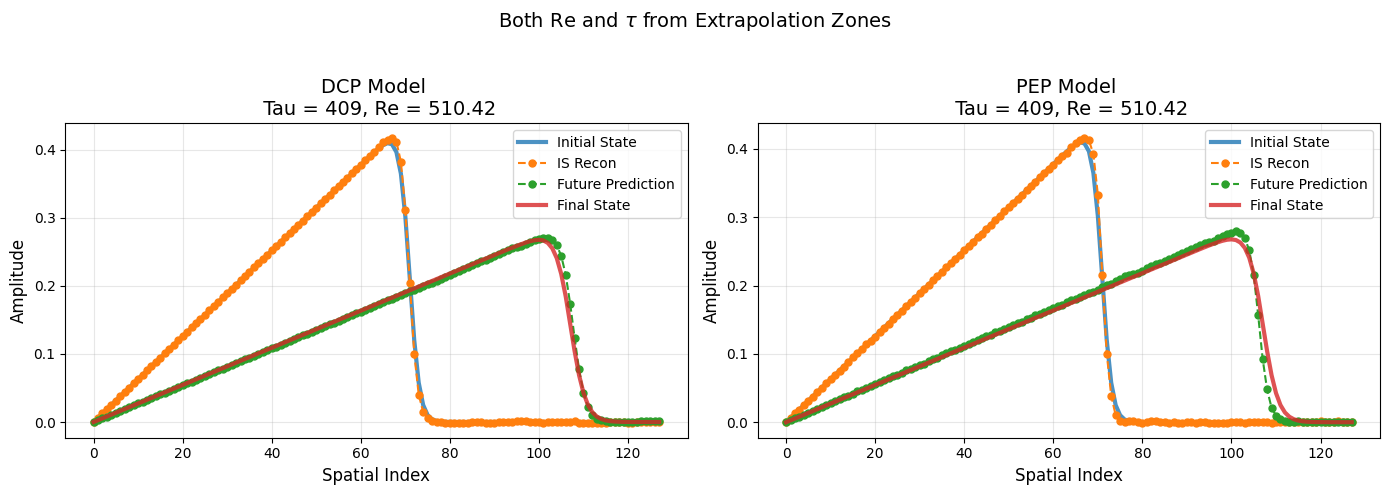

In [8]:
# Choose some Re and Tau in the test combinations
Re_value = np.random.uniform(*re_interval_split.extrapolation_left)  # Randomly selected from R validation zones - in Re

t_0 = 0.25  # Or you can use np.random.uniform(*TRANGE) - don't keep too close to 0
dt = 2.0 / 500.0
tau = np.random.uniform(*tau_interval_split.extrapolation_right)  # In the R Extrap region of tau

x_t = exact_solution(Re_value, t_0)
tau = torch.tensor([tau]).float()[:, None]
Re_tensor = torch.tensor([Re_value]).float()[:, None]
xt = torch.tensor([x_t]).float()[:, None]
t_final = (t_0 + tau * dt).squeeze().item()

x_exact = exact_solution(Re_value, t_final)

# Predictions from both models
with torch.no_grad():
    x_hat_concat, x_hat_tau_concat, _, _, _ = best_concat_model(xt, tau, Re_tensor)
    x_hat_hde, x_hat_tau_hde, _, _, _ = best_HDE_model(xt, tau, Re_tensor)

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plt.suptitle("Both Re and $\\tau$ from Extrapolation Zones", fontsize=14)

# Model Names for Titles
models = ["DCP Model", "PEP Model"]
x_hats = [x_hat_concat, x_hat_hde]
x_hat_taus = [x_hat_tau_concat, x_hat_tau_hde]

for i, ax in enumerate(axes):
    ax.plot(
        xt.squeeze(),
        label="Initial State",
        linewidth=3,
        alpha=0.8,
        color="C0"
    )

    ax.plot(
        x_hats[i].squeeze(),
        label="IS Recon",
        marker='o',
        linestyle='--',
        linewidth=1.5,
        markersize=5,
        color="C1"
    )

    ax.plot(
        x_hat_taus[i].squeeze(),
        label="Future Prediction",
        marker='o',
        linestyle='--',
        linewidth=1.5,
        markersize=5,
        color="C2"
    )

    ax.plot(
        x_exact.squeeze(),
        label="Final State",
        linewidth=3,
        alpha=0.8,
        color="C3"
    )

    ax.set_title(
        f"{models[i]} \n Tau = {int(tau.squeeze().numpy())}, Re = {Re_value:.2f}",
        fontsize=14
    )
    ax.set_xlabel("Spatial Index", fontsize=12)
    ax.set_ylabel("Amplitude", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

#### One result from DC - P Model

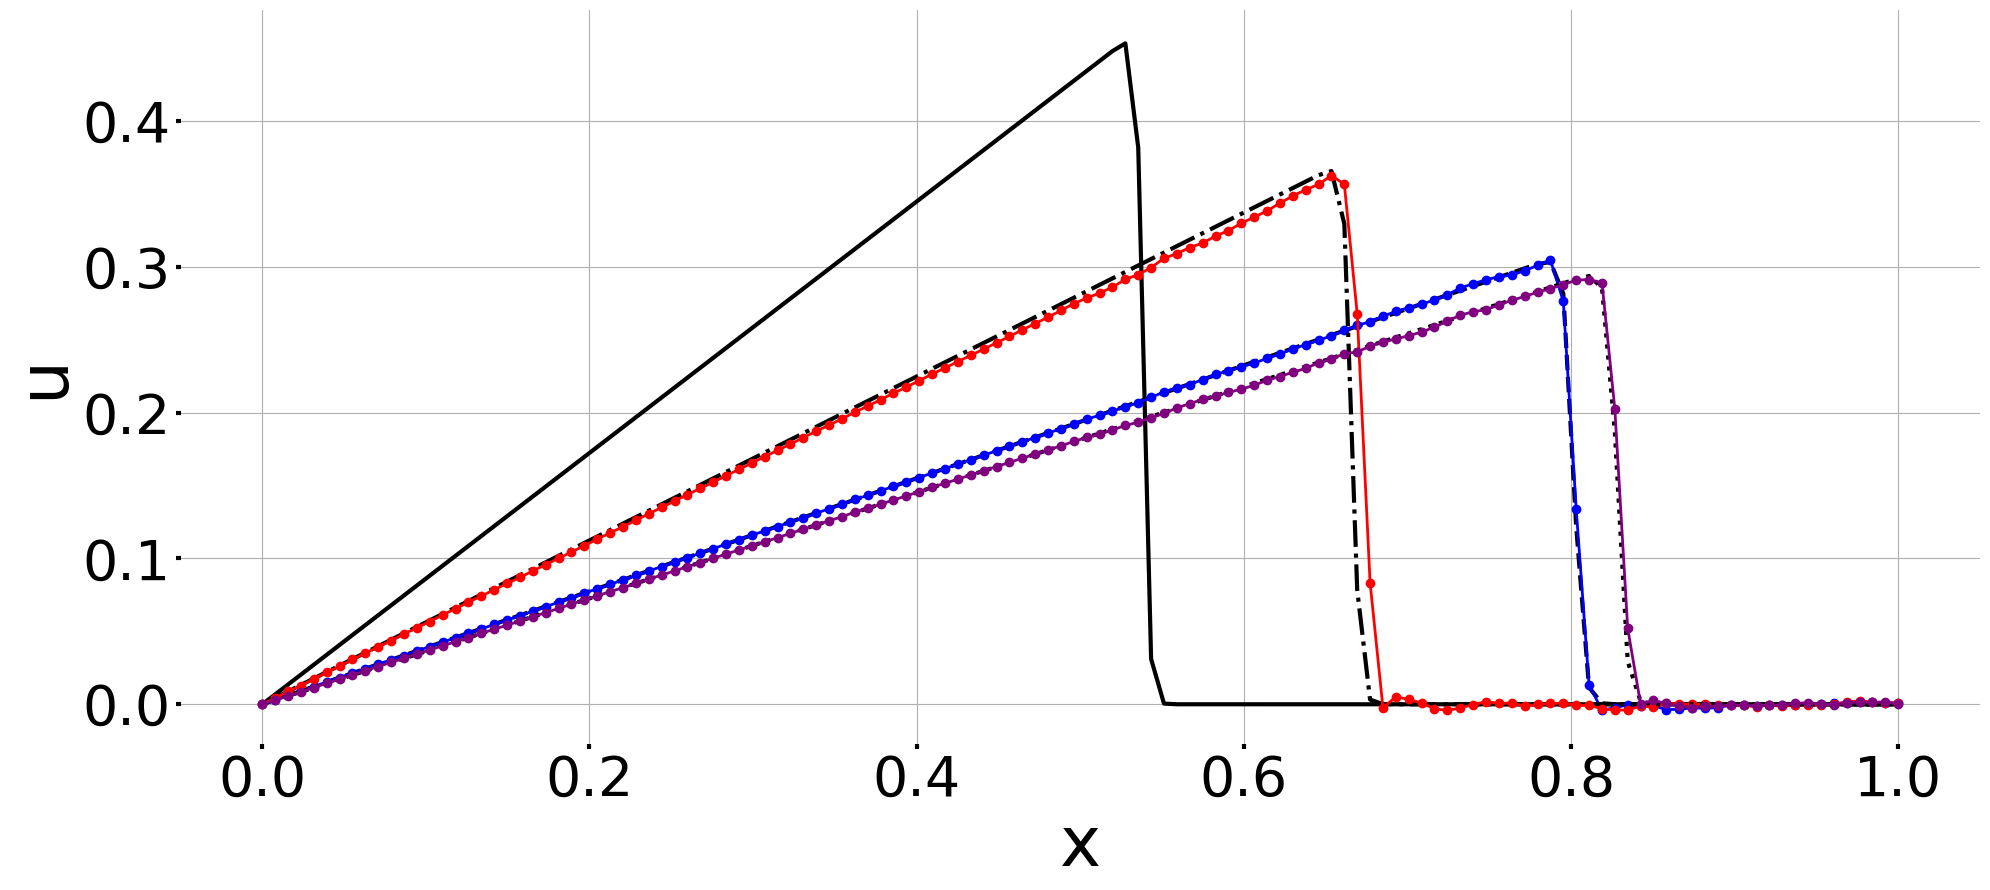

In [9]:
# Generate initial x_t
TRANGE = (0, 2)
x = np.linspace(0.0,1.0,num=128)
# Re_range = re_interval_split.interpolation
# logRe = np.random.uniform(np.log(Re_range[0]), np.log(Re_range[1]))
# Re_value = np.exp(logRe).round().astype(int)
Re_value = 2300  # Some value chosen in the interpolation range
t = 0.16  # Or you can use np.random.uniform(*TRANGE)
dt = 2.0 / 500.0
x_t = exact_solution(Re_value, t)

# Sample tau values for left extrapolation, interpolation, right extrapolation
tau_extrap_left = np.random.uniform(*tau_interval_split.extrapolation_left)
tau_extrap_right = np.random.uniform(*tau_interval_split.extrapolation_right)
tau_interp = np.random.uniform(*tau_interval_split.interpolation)

# Compute exact solutions at t + tau * dt
x_tau_extrap_left, x_tau_extrap_right, x_tau_interp = [
    exact_solution(Re_value, t + T * dt) for T in [tau_extrap_left, tau_extrap_right, tau_interp]
]

# Prepare inputs for the model
tau = torch.tensor([tau_extrap_left, tau_extrap_right, tau_interp]).float()[:, None]
Re_tensor = torch.tensor([Re_value, Re_value, Re_value]).float()[:, None]
xt = torch.tensor([x_t] * 3).float()[:, None]

# Make predictions with the model
with torch.no_grad():
    x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, tau, Re_tensor)

# Extract predicted x_hat_tau values
x_hat_tau_extrap_left, x_hat_tau_extrap_right, x_hat_tau_interp = x_hat_tau.squeeze().numpy()

# Begin plotting
plt.figure(figsize=(20, 9))
#plt.suptitle("Multiple single shot pred: DC - P Model", fontsize = 32)

# Plot initial state and its reconstruction
plt.plot(x, x_t, label=r"Initial Condition $x(t)$", color='black', linestyle='-', linewidth=3)
#plt.plot(x_hat[0].squeeze().numpy(), label=r"Predicted $\hat{x}(t)$", color='green', marker='o', linewidth=2)

# Plot exact and predicted future states for interpolation
plt.plot(x, x_tau_interp, label=r"Exact $x(t + \tau_{\mathrm{I}})$", color='black', linestyle='--', linewidth=3)
plt.plot(x, x_hat_tau_interp, label=r"Predicted $\hat{x}(t + \tau_{\mathrm{I}})$", color='blue', marker='o', linewidth=2)

# Plot exact and predicted future states for left extrapolation
plt.plot(x, x_tau_extrap_left, label=r"Exact $x(t + \tau_{\mathrm{LE}})$", color='black', linestyle='-.', linewidth=3)
plt.plot(x, x_hat_tau_extrap_left, label=r"Predicted $\hat{x}(t + \tau_{\mathrm{LE}})$", color='red', marker='o', linewidth=2)

# Plot exact and predicted future states for right extrapolation
plt.plot(x, x_tau_extrap_right, label=r"Exact $x(t + \tau_{\mathrm{RE}})$", color='black', linestyle=':', linewidth=3)
plt.plot(x, x_hat_tau_extrap_right, label=r"Predicted $\hat{x}(t + \tau_{\mathrm{RE}})$", color='purple', marker='o', linewidth=2)

# Create the plot title with all tau values using LaTeX formatting
# plt.title(
#     r"$\mathrm{{Re}} = {:.1f},\ \tau_{{\mathrm{{LE}}}} = {:.2f},\ \tau_{{\mathrm{{I}}}} = {:.2f},\ \tau_{{\mathrm{{RE}}}} = {:.2f}$".format(
#         Re_value, int(tau_extrap_left), int(tau_interp), int(tau_extrap_right)
#     ),
#     fontsize=35
# )

plt.xlabel("x", fontsize=50)
plt.ylabel("u", fontsize=50)

# # Adjust axis appearance
# ax = plt.gca()
# for axis in ['top', 'bottom', 'left', 'right']:
#     ax.spines[axis].set_linewidth(3)
# ax.tick_params(axis='both', which='major', labelsize=30, width=3)

# Adjust axis appearance: remove the box (all spines)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=40, width=3)


#plt.legend(fontsize=25)
plt.grid(True)
plt.tight_layout()
#plt.savefig("Axis_3_res")
plt.show()

### MSE over all testing regions: DCP Vs PEP

In [10]:
def calculate_mse_with_tracking(re_interval_split, tau_interval_split, exact_solution, dt,
                                best_concat_model, best_HDE_model, n_samples=500):
    """Complete workflow with value tracking"""
    # Initialize value containers
    re_values_val = []
    tau_values_val = []

    # Generate boundary values
    Re_left = np.random.uniform(*re_interval_split.extrapolation_left)
    Re_interp = np.random.uniform(*re_interval_split.interpolation)
    Re_right = np.random.uniform(*re_interval_split.extrapolation_right)

    tau_left = np.random.uniform(*tau_interval_split.extrapolation_left)
    tau_interp = np.random.uniform(*tau_interval_split.interpolation)
    tau_right = np.random.uniform(*tau_interval_split.extrapolation_right)

    # Define all testing combinations
    combinations = [
        (Re_left, tau_left), (Re_left, tau_interp), (Re_left, tau_right),
        (Re_interp, tau_left), (Re_interp, tau_interp), (Re_interp, tau_right),
        (Re_right, tau_left), (Re_right, tau_interp), (Re_right, tau_right)
    ]

    # Results storage
    mse_results_concat = {}
    mse_results_hde = {}
    TRANGE = (0, 2)

    # Main evaluation loop
    for Re_val, tau_val in combinations:
        errors_concat = []
        errors_hde = []
        re_samples = []
        tau_samples = []
        sample_count = 0

        while sample_count < n_samples:
            # Generate sample
            t = np.random.uniform(*TRANGE)
            x_t = exact_solution(Re_val, t)
            x_tau_exact = exact_solution(Re_val, t + tau_val * dt)

            # Model predictions
            tau_tensor = torch.tensor([tau_val]).float().reshape(1, 1)
            Re_tensor = torch.tensor([Re_val]).float().reshape(1, 1)
            x_t_tensor = torch.tensor(x_t).float()[None, None, :]

            # Concatenation model
            with torch.no_grad():
                _, x_hat_tau_concat, _, _, _ = best_concat_model(x_t_tensor, tau_tensor, Re_tensor)
            x_tau_pred_concat = x_hat_tau_concat.squeeze().numpy()

            # HDE model
            with torch.no_grad():
                _, x_hat_tau_hde, _, _, _ = best_HDE_model(x_t_tensor, tau_tensor, Re_tensor)
            x_tau_pred_hde = x_hat_tau_hde.squeeze().numpy()

            # Calculate errors
            error_concat = mean_squared_error(x_tau_exact, x_tau_pred_concat)
            error_hde = mean_squared_error(x_tau_exact, x_tau_pred_hde)

            # Store results
            errors_concat.append(error_concat)
            errors_hde.append(error_hde)
            re_samples.append(Re_val)
            tau_samples.append(tau_val)
            sample_count += 1

        # Update global value lists
        re_values_val.extend(re_samples)
        tau_values_val.extend(tau_samples)

        # Store average MSE
        Re_label = 'left' if Re_val == Re_left else 'interp' if Re_val == Re_interp else 'right'
        tau_label = 'left' if tau_val == tau_left else 'interp' if tau_val == tau_interp else 'right'
        
        mse_results_concat[f"Re_{Re_label}-tau_{tau_label}"] = np.mean(errors_concat)
        mse_results_hde[f"Re_{Re_label}-tau_{tau_label}"] = np.mean(errors_hde)

    # Print results
    print("MSE Results for DCP Model:")
    for label, mse in mse_results_concat.items():
        print(f"{label}: {mse:.4e}")

    print("\nMSE Results for PEP Model:")
    for label, mse in mse_results_hde.items():
        print(f"{label}: {mse:.4e}")

    return re_values_val, tau_values_val, mse_results_concat, mse_results_hde


re_vals, tau_vals, mse_concat, mse_hde = calculate_mse_with_tracking(
    re_interval_split,
    tau_interval_split,
    exact_solution,
    dt,
    best_concat_model,
    best_HDE_model,
    n_samples = 300 #30000
)

MSE Results for DCP Model:
Re_left-tau_left: 1.4836e-04
Re_left-tau_interp: 6.1363e-05
Re_left-tau_right: 4.6318e-05
Re_interp-tau_left: 1.3295e-05
Re_interp-tau_interp: 3.5914e-06
Re_interp-tau_right: 4.4489e-06
Re_right-tau_left: 2.3429e-05
Re_right-tau_interp: 6.2350e-06
Re_right-tau_right: 4.2451e-06

MSE Results for PEP Model:
Re_left-tau_left: 4.3095e-04
Re_left-tau_interp: 4.7393e-04
Re_left-tau_right: 4.7098e-04
Re_interp-tau_left: 1.7996e-05
Re_interp-tau_interp: 4.4192e-06
Re_interp-tau_right: 6.5240e-06
Re_right-tau_left: 9.0812e-04
Re_right-tau_interp: 3.9946e-04
Re_right-tau_right: 4.4581e-04


In [11]:
def plot_alpha_tau_scatter(alpha_values,
                           tau_values,
                           alpha_interval_split,
                           tau_interval_split,
                           mse_dict=None,
                           figsize=(9, 5),
                           point_size=5,
                           point_alpha=0.05,
                           color_alpha=0.55):
    fig, ax = plt.subplots(figsize=figsize)

    # Add colored regions if MSE data is provided
    if mse_dict is not None:
        mse_values = list(mse_dict.values())
        norm = plt.Normalize(vmin=min(mse_values), vmax=max(mse_values))
        cmap = plt.cm.jet

        interval_parts = ['left', 'interp', 'right']
        
        for re_part in interval_parts:
            if re_part == 'left':
                a_min, a_max = alpha_interval_split.extrapolation_left
            elif re_part == 'interp':
                a_min, a_max = alpha_interval_split.interpolation
            else:
                a_min, a_max = alpha_interval_split.extrapolation_right

            for tau_part in interval_parts:
                if tau_part == 'left':
                    t_min, t_max = tau_interval_split.extrapolation_left
                elif tau_part == 'interp':
                    t_min, t_max = tau_interval_split.interpolation
                else:
                    t_min, t_max = tau_interval_split.extrapolation_right

                key = f"Re_{re_part}-tau_{tau_part}"
                if (mse := mse_dict.get(key)) is None:
                    continue
                
                rect = patches.Rectangle(
                    (a_min, t_min), a_max - a_min, t_max - t_min,
                    facecolor=cmap(norm(mse)), alpha=color_alpha, edgecolor='black'
                )
                ax.add_patch(rect)


    #ax.scatter(alpha_values, tau_values, s=point_size, alpha=point_alpha, color='blue')
    ax.set_xlabel('Re', fontsize=28)
    ax.set_ylabel(r'$\tau$', fontsize=28)

    
#    ax.set_title('MSE Validation Zones', fontsize=16)

    # Dashed lines for interval boundaries
    alpha_boundaries = sorted([*alpha_interval_split.extrapolation_left,
                               *alpha_interval_split.interpolation,
                               *alpha_interval_split.extrapolation_right])
    tau_boundaries = sorted([*tau_interval_split.extrapolation_left,
                             *tau_interval_split.interpolation,
                             *tau_interval_split.extrapolation_right])
    
    for a_line in alpha_boundaries:
        ax.axvline(a_line, color='black', linestyle='--', linewidth=1.5)
    
    for t_line in tau_boundaries:
        ax.axhline(t_line, color='black', linestyle='--', linewidth=1.5)

    plt.tight_layout()
    plt.xticks(fontsize = 20)
    y_ticks = ax.get_yticks()
    new_labels = [f"{tick * dt:.3f}" for tick in y_ticks]  # Formats the label to 3 decimal places
    ax.set_yticklabels(new_labels, fontsize = 20)
    #plt.savefig("split")
    plt.show()

## DCP

/tmp/ipykernel_474850/1080816310.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels, fontsize = 20)


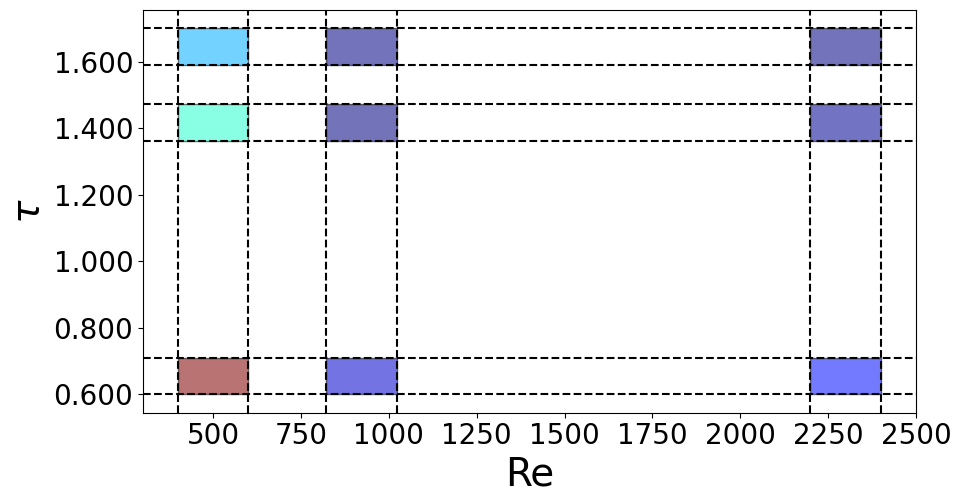

In [12]:
from matplotlib import patches
plot_alpha_tau_scatter(
    re_vals,
    tau_vals,
    re_interval_split,
    tau_interval_split,
    mse_dict=mse_concat
)

/tmp/ipykernel_474850/1260468404.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


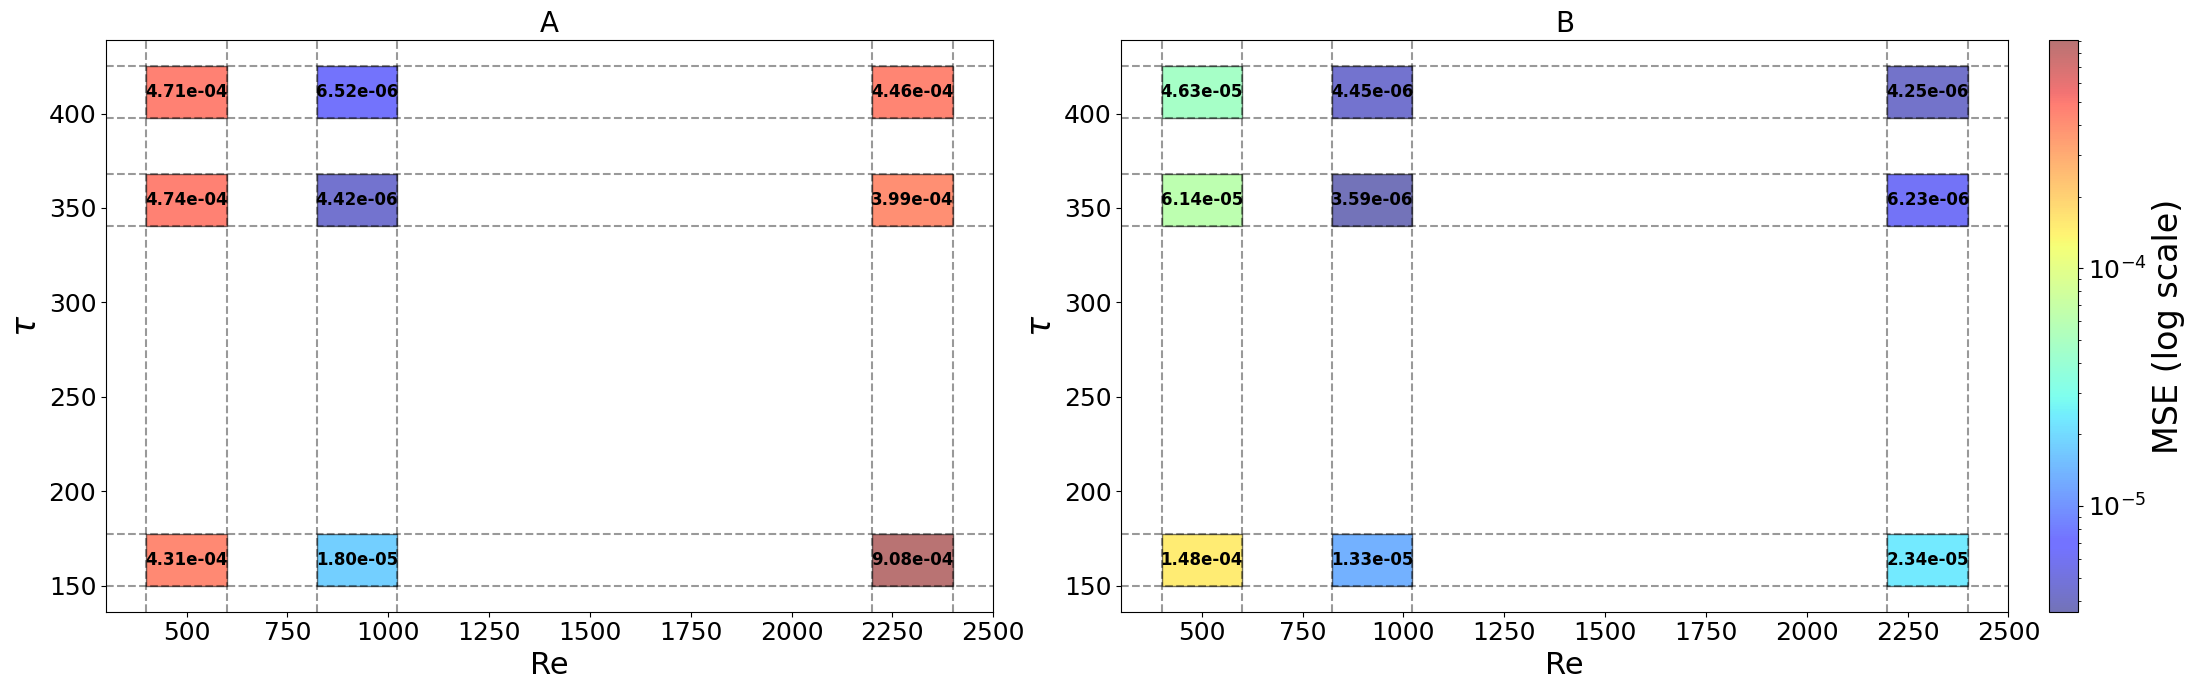

In [13]:
from matplotlib import patches
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm 

def plot_alpha_tau_scatter(alpha_values, tau_values, alpha_interval_split, tau_interval_split,
                           mse_dict=None, figsize=(11, 6), point_size=5, point_alpha=0.05,
                           color_alpha=0.55, ax=None, norm=None, cmap=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # Add colored regions if MSE data is provided
    if mse_dict is not None:
        mse_values = list(mse_dict.values())
        
        # Use the provided normalization or create a new one
        if norm is None:
            # Change from plt.Normalize to LogNorm
            norm = LogNorm(vmin=min(mse_values), vmax=max(mse_values))
        if cmap is None:
            cmap = plt.cm.jet

        interval_parts = ['left', 'interp', 'right']
        
        for re_part in interval_parts:
            if re_part == 'left':
                a_min, a_max = alpha_interval_split.extrapolation_left
            elif re_part == 'interp':
                a_min, a_max = alpha_interval_split.interpolation
            else:
                a_min, a_max = alpha_interval_split.extrapolation_right

            for tau_part in interval_parts:
                if tau_part == 'left':
                    t_min, t_max = tau_interval_split.extrapolation_left
                elif tau_part == 'interp':
                    t_min, t_max = tau_interval_split.interpolation
                else:
                    t_min, t_max = tau_interval_split.extrapolation_right

                key = f"Re_{re_part}-tau_{tau_part}"
                mse = mse_dict.get(key)
                if mse is None:
                    continue
                
                rect = patches.Rectangle(
                    (a_min, t_min), a_max - a_min, t_max - t_min,
                    facecolor=cmap(norm(mse)), alpha=color_alpha, edgecolor='black'
                )
                ax.add_patch(rect)

                # For text, we keep scientific notation
                ax.text((a_min + a_max) / 2, (t_min + t_max) / 2,
                        f"{mse:.2e}", color='black', ha='center', va='center', fontsize=12, weight="bold")

    ax.set_xlabel('Re', fontsize=22)
    ax.set_ylabel(r'$\tau$', fontsize=24)

    # Draw dashed lines for interval boundaries
    alpha_boundaries = sorted([*alpha_interval_split.extrapolation_left,
                               *alpha_interval_split.interpolation,
                               *alpha_interval_split.extrapolation_right])
    tau_boundaries = sorted([*tau_interval_split.extrapolation_left,
                             *tau_interval_split.interpolation,
                             *tau_interval_split.extrapolation_right])
    
    for a_line in alpha_boundaries:
        ax.axvline(a_line, color='black', linestyle='--', linewidth=1.5, alpha = 0.4)
    
    for t_line in tau_boundaries:
        ax.axhline(t_line, color='black', linestyle='--', linewidth=1.5, alpha = 0.4)

    # Increase the x/y tick font size
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()
    return fig, ax, norm, cmap


# --------------------------------------------------------------------
# Main plotting code
# --------------------------------------------------------------------
# Combine MSE values from both dictionaries to get global min and max
mse_concat_values = list(mse_concat.values())
mse_hde_values = list(mse_hde.values())
global_min = min(min(mse_concat_values), min(mse_hde_values))
global_max = max(max(mse_concat_values), max(mse_hde_values))

# Instead of linear Normalize, use LogNorm globally
log_norm = LogNorm(vmin=global_min, vmax=global_max)

# Create a figure with two subplots using constrained_layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 7), constrained_layout=True)

# Plot the first subplot with PEP results (mse_hde)
plot_alpha_tau_scatter(
    re_vals, tau_vals,
    re_interval_split, tau_interval_split,
    mse_dict=mse_hde,
    ax=ax1,
    norm=log_norm  # <-- use LogNorm
)
ax1.set_title('A', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=18)

# Plot the second subplot with DCP results (mse_concat)
plot_alpha_tau_scatter(
    re_vals, tau_vals,
    re_interval_split, tau_interval_split,
    mse_dict=mse_concat,
    ax=ax2,
    norm=log_norm  # <-- use LogNorm
)
ax2.set_title('B', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=18)

# Add a single shared colorbar on the right side
sm = ScalarMappable(norm=log_norm, cmap=plt.cm.jet)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1, ax2], location='right', fraction=0.05, pad=0.02, alpha=0.55)
cbar.set_label('MSE (log scale)', fontsize=24)
cbar.ax.tick_params(labelsize=18)

#plt.savefig("MSE_errors_log.png")
plt.show()

## AE LSTM Model

In [14]:
from LSTM_model import AE_Encoder, AE_Decoder, AE_Model, PytorchLSTM, measure_lstm_prediction_time, collect_snapshots 
from LSTM_model import collect_multiparam_snapshots_train, collect_multiparam_snapshots_test, exact_solution

Final time is: 2.06000018119812
Shapes: torch.Size([1, 1]) torch.Size([1, 1]) torch.Size([1, 1, 128])
Predicted Shapes: torch.Size([1, 1, 128]) torch.Size([1, 1, 128])
Elapsed Time: 0.003575 seconds


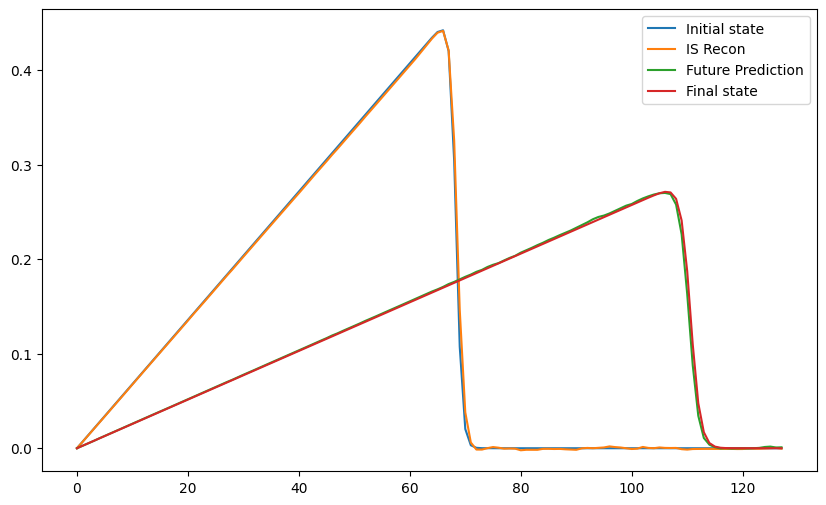

In [15]:
# Define parameters
Re_value = 1020
t_0 = 0.16  # Or use np.random.uniform(*TRANGE)
dt = 2.0 / 500.0
tau = 475

# Generate initial condition and target final state
x_t = exact_solution(Re_value, t_0)
tau = torch.tensor([tau], dtype=torch.float32)[:, None]
Re_tensor = torch.tensor([Re_value], dtype=torch.float32)[:, None]
xt = torch.tensor([x_t], dtype=torch.float32)[:, None]
t_final = (t_0 + tau * dt).squeeze().item()

print("Final time is:", t_final)
print("Shapes:", tau.shape, Re_tensor.shape, xt.shape)

x_exact = exact_solution(Re_value, t_final)

# Ensure model is in evaluation mode
best_concat_model.eval()

# Move tensors to same device as model
device = next(best_concat_model.parameters()).device
xt, tau, Re_tensor = xt.to(device), tau.to(device), Re_tensor.to(device)

# Synchronize before timing (if using GPU)
if torch.cuda.is_available():
    torch.cuda.synchronize()

start_time = time.time()

# Perform inference
with torch.no_grad():
    x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, tau, Re_tensor)

# Synchronize after timing (if using GPU)
if torch.cuda.is_available():
    torch.cuda.synchronize()

end_time = time.time()
lapsed = end_time - start_time

print("Predicted Shapes:", x_hat.shape, x_hat_tau.shape)
print("Elapsed Time: {:.6f} seconds".format(lapsed))

# Move tensors to CPU for plotting
xt_cpu = xt.squeeze().cpu().numpy()
x_hat_cpu = x_hat.squeeze().cpu().numpy()
x_hat_tau_cpu = x_hat_tau.squeeze().cpu().numpy()
x_exact_cpu = x_exact.squeeze()  # Assuming this is already a NumPy array

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(xt_cpu, label="Initial state")
plt.plot(x_hat_cpu, label="IS Recon")
plt.plot(x_hat_tau_cpu, label="Future Prediction")
plt.plot(x_exact_cpu, label="Final state")
plt.legend()
plt.show()

### Loading the AE and LSTM model

In [16]:
# Loading the model weights: Model, Decoder, LSTM
ae_encoder_path = "./LSTM_model/ae_encoder_weights.pth"
ae_decoder_path = "./LSTM_model/ae_decoder_weights.pth"
ae_model_path = "./LSTM_model/ae_model.pth"
lstm_path = "./LSTM_model/lstm_weights.pth"

In [17]:
# Define the same architectures
AE_encoder = AE_Encoder(input_dim=128) 
AE_decoder = AE_Decoder(latent_dim=2, output_dim=128) 
ae_model = AE_Model(AE_encoder, AE_decoder) 
lstm_model = PytorchLSTM() 

# Load the saved weights
AE_encoder.load_state_dict(torch.load(ae_encoder_path))
AE_decoder.load_state_dict(torch.load(ae_decoder_path))
ae_model.load_state_dict(torch.load(ae_model_path))
lstm_model.load_state_dict(torch.load(lstm_path))

# Set models to evaluation mode if needed
AE_encoder.eval()
AE_decoder.eval()
ae_model.eval()
lstm_model.eval()

print("Model weights loaded successfully.")

Model weights loaded successfully.


### Checking device for models

In [18]:
for name, param in ae_model.named_parameters():
    print(f"Layer: {name} | Device: {param.device}")

Layer: encoder._net.0.weight | Device: cpu
Layer: encoder._net.0.bias | Device: cpu
Layer: encoder._net.2.weight | Device: cpu
Layer: encoder._net.2.bias | Device: cpu
Layer: encoder._net.4.weight | Device: cpu
Layer: encoder._net.4.bias | Device: cpu
Layer: encoder._net.6.weight | Device: cpu
Layer: encoder._net.6.bias | Device: cpu
Layer: encoder._net.8.weight | Device: cpu
Layer: encoder._net.8.bias | Device: cpu
Layer: encoder._net.10.weight | Device: cpu
Layer: encoder._net.10.bias | Device: cpu
Layer: decoder._net.0.weight | Device: cpu
Layer: decoder._net.0.bias | Device: cpu
Layer: decoder._net.2.weight | Device: cpu
Layer: decoder._net.2.bias | Device: cpu
Layer: decoder._net.4.weight | Device: cpu
Layer: decoder._net.4.bias | Device: cpu
Layer: decoder._net.6.weight | Device: cpu
Layer: decoder._net.6.bias | Device: cpu
Layer: decoder._net.8.weight | Device: cpu
Layer: decoder._net.8.bias | Device: cpu
Layer: decoder._net.10.weight | Device: cpu
Layer: decoder._net.10.bias | 

In [19]:
for name, param in lstm_model.named_parameters():
    print(f"Layer: {name} | Device: {param.device}")

Layer: lstm1.weight_ih_l0 | Device: cpu
Layer: lstm1.weight_hh_l0 | Device: cpu
Layer: lstm1.bias_ih_l0 | Device: cpu
Layer: lstm1.bias_hh_l0 | Device: cpu
Layer: lstm2.weight_ih_l0 | Device: cpu
Layer: lstm2.weight_hh_l0 | Device: cpu
Layer: lstm2.bias_ih_l0 | Device: cpu
Layer: lstm2.bias_hh_l0 | Device: cpu
Layer: fc.weight | Device: cpu
Layer: fc.bias | Device: cpu


In [20]:
output_seq_pred_train = "./LSTM_model/output_seq_pred_train.npy"
output_seq_train = "./LSTM_model/output_seq_train.npy"
lstm_testing_data = "./LSTM_model/lstm_testing_data.npy"

output_seq_pred_train = np.load(output_seq_pred_train)
output_seq_train = np.load(output_seq_train)
lstm_testing_data = np.load(lstm_testing_data)

print(output_seq_pred_train.shape, output_seq_train.shape, lstm_testing_data.shape)

(25760, 2) (25760, 2) (5, 500, 3)


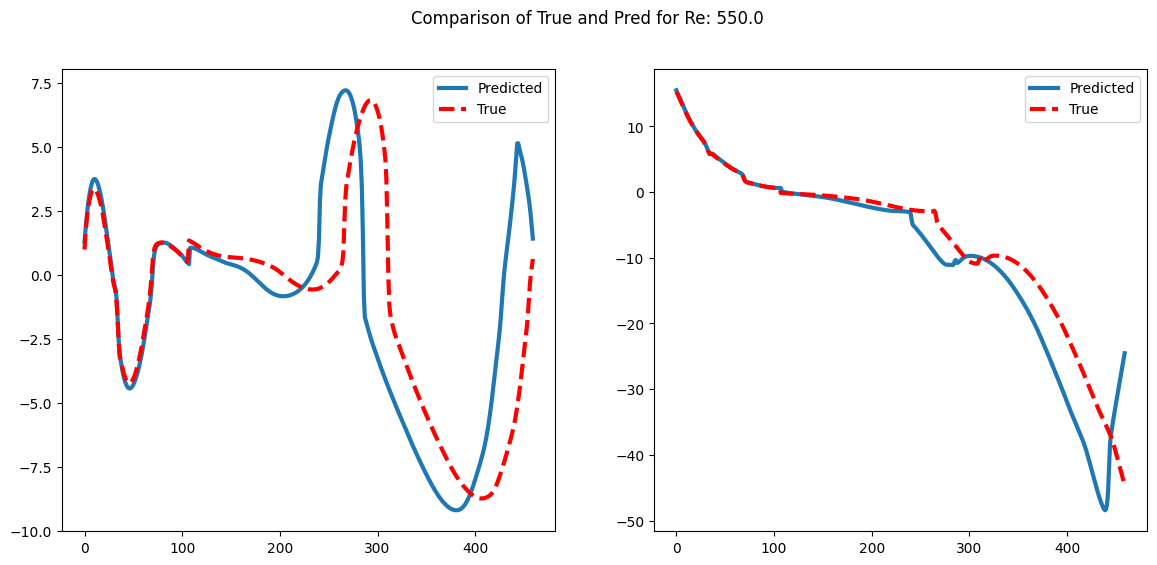

In [21]:
# Prediction of evolution of LS by the LSTM Model for test Re
num_test_snapshots, num_time_steps, _ = lstm_testing_data.shape

sim_num = 0
time_window = 40
num_time_steps = 500

# We'll do 90 predictions after the initial 10
samples_to_predict = num_time_steps - time_window  # 90

# ---------------------------
# 2) Prepare a rolling buffer & arrays to store predictions
# ---------------------------
input_seq = np.zeros((1, time_window, 3), dtype=np.float32)
predictions = np.zeros((samples_to_predict, 2), dtype=np.float32)
y_true = np.zeros((samples_to_predict, 2), dtype=np.float32)

# Initialize the first 10 steps from the data
input_seq[0, :, :] = lstm_testing_data[sim_num, 0:time_window, :]

# ---------------------------
# 3) Autoregressive loop
# ---------------------------
sample = 0
lstm_model.eval()

with torch.no_grad():
    for t in range(time_window, num_time_steps):  # from 10..99
        # Convert to PyTorch tensor
        inp_tensor = torch.from_numpy(input_seq).float()  # shape [1, 10, 3]
        
        # Forward pass
        pred = lstm_model(inp_tensor)               # shape [1, 2]
        pred_np = pred.numpy()[0, :]           # shape [2,]
        
        # Store prediction & ground truth
        predictions[sample, :] = pred_np
        y_true[sample, :] = lstm_testing_data[sim_num, t, 0:2]  # Fix here
        
        # Shift the rolling window by 1
        temp = input_seq[0, 1:time_window, :].copy()
        input_seq[0, 0:time_window-1, :] = temp
        input_seq[0, time_window-1, 0:2] = pred_np
        
        sample += 1

# ---------------------------
# 4) Plot predictions vs. ground truth
# ---------------------------
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the first latent dimension
ax[0].plot(predictions[:, 0], label='Predicted', linewidth=3)
ax[0].plot(lstm_testing_data[sim_num, time_window:, 0], 'r--', label='True', linewidth=3)
ax[0].legend()

# Plot the second latent dimension
ax[1].plot(predictions[:, 1], label='Predicted', linewidth=3)
ax[1].plot(lstm_testing_data[sim_num, time_window:, 1], 'r--', label='True', linewidth=3)
ax[1].legend()

r_num = (np.unique(lstm_testing_data[sim_num, time_window:, 2])*1000).squeeze()
plt.suptitle(f"Comparison of True and Pred for Re: {r_num}")
plt.show()

In [22]:
sim_num = 0
final_time = 445  # predict the 445th latent
elapsed_sec, pred_latent, true_latent = measure_lstm_prediction_time(AE_decoder, lstm_model, lstm_testing_data, sim_num, final_time, time_window=40)

print(f"Time to predict up to t={final_time}: {elapsed_sec:.4f} s")
print("Predicted latent at final_time:", pred_latent)
print("True latent at final_time:", true_latent)

Time to predict up to t=445: 0.1821 s
Predicted latent at final_time: [ -7.4915485 -33.490883 ]
True latent at final_time: [ -8.73652935 -23.50485229]


In [23]:
num_time_steps = 500
x = np.linspace(0.0,1.0,num=128)
dx = 1.0/np.shape(x)[0]
tsteps = np.linspace(0.0,2.0,num=num_time_steps)
dt = 2.0/np.shape(tsteps)[0]
time_window = 40 # The window size of the LSTM

snapshots_train, rnum_vals_train = collect_multiparam_snapshots_train() # So that dim=0 corresponds to number of snapshots
snapshots_test, rnum_vals_test = collect_multiparam_snapshots_test() # So that dim=0 corresponds to number of snapshots
rnum_vals_test*1000

array([ 550., 1025., 1500., 1975., 2450.])

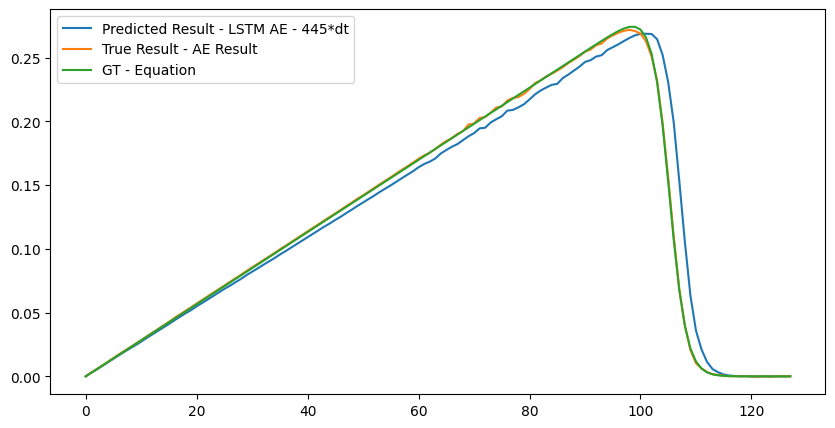

In [24]:
# Passing the latent into the decoder:
x_hat_tau_pred = AE_decoder(torch.tensor(pred_latent, dtype = torch.float32))
x_hat_tau = AE_decoder(torch.tensor(true_latent, dtype = torch.float32))
exact = exact_solution(rnum_vals_test[sim_num]*1000, final_time*dt)

plt.figure(figsize = (10, 5))
plt.plot(x_hat_tau_pred.cpu().detach().numpy(), label = "Predicted Result - LSTM AE - 445*dt")
plt.plot(x_hat_tau.cpu().detach().numpy(), label = "True Result - AE Result")
plt.plot(exact, label = "GT - Equation")

plt.legend();

In [25]:
for name, param in best_concat_model.named_parameters():
    print(f"Layer: {name} | Device: {param.device}")

Layer: encoder._net.0.weight | Device: cpu
Layer: encoder._net.0.bias | Device: cpu
Layer: encoder._net.2.norm.weight | Device: cpu
Layer: encoder._net.2.norm.bias | Device: cpu
Layer: encoder._net.3.weight | Device: cpu
Layer: encoder._net.3.bias | Device: cpu
Layer: encoder._net.5.norm.weight | Device: cpu
Layer: encoder._net.5.norm.bias | Device: cpu
Layer: encoder._net.6.weight | Device: cpu
Layer: encoder._net.6.bias | Device: cpu
Layer: encoder._net.8.norm.weight | Device: cpu
Layer: encoder._net.8.norm.bias | Device: cpu
Layer: encoder._net.9.weight | Device: cpu
Layer: encoder._net.9.bias | Device: cpu
Layer: encoder._net.11.norm.weight | Device: cpu
Layer: encoder._net.11.norm.bias | Device: cpu
Layer: encoder._net.12.weight | Device: cpu
Layer: encoder._net.12.bias | Device: cpu
Layer: encoder._net.14.norm.weight | Device: cpu
Layer: encoder._net.14.norm.bias | Device: cpu
Layer: encoder._net.15.weight | Device: cpu
Layer: encoder._net.15.bias | Device: cpu
Layer: decoder._ne

## Accuracy Comparison FVAE VS AE-LSTM

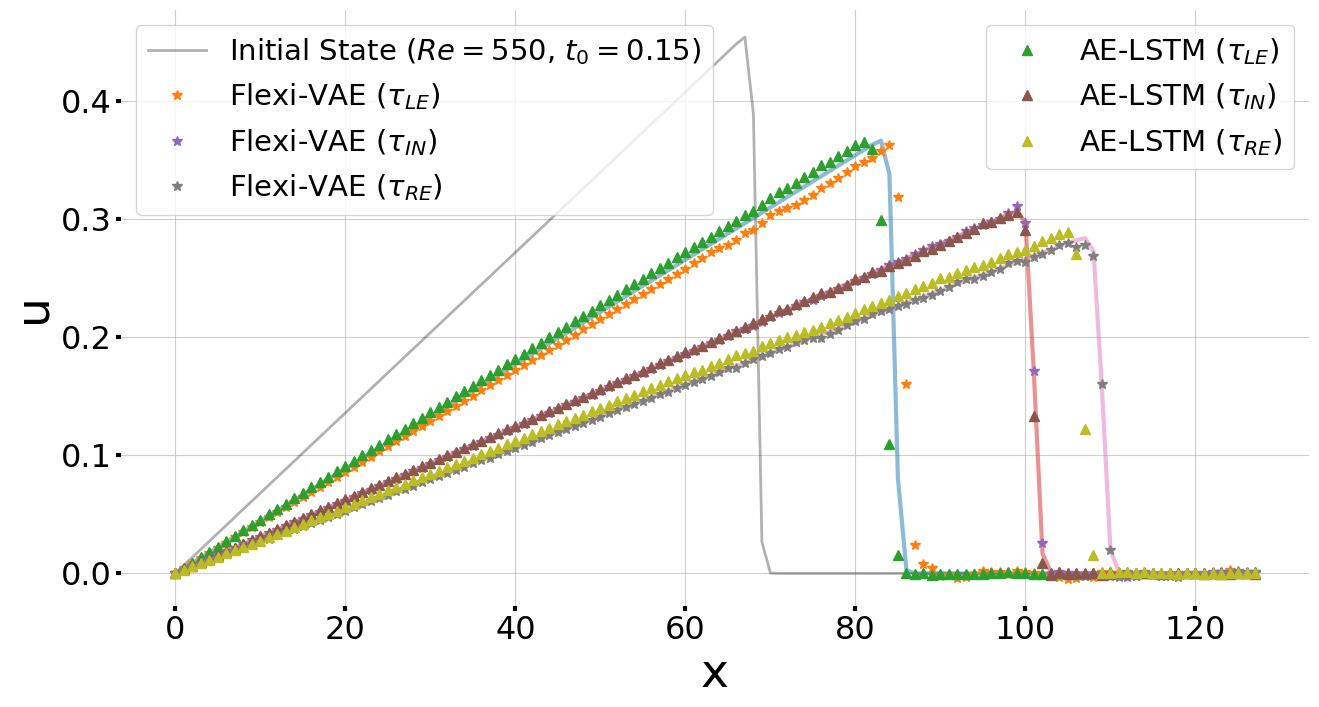

In [26]:
# Simulation setup
sim_num = -1

re_1 = rnum_vals_test[sim_num]
Re_value = re_1 * 1000
t_0 = 0.16  # Initial time 
dt = 2.0 / 500.0
taus = [155, 345, 450]  # Time shifts for analysis

# Initial state
x_t = exact_solution(Re_value, t_0)
Re_tensor = torch.tensor([Re_value]).float()[:, None]
xt = torch.tensor([x_t]).float()[:, None]

# Initialize plot
plt.figure(figsize=(13, 7))

# Set axis thickness
plt.rc('axes', linewidth=2)

# Plot the initial state
plt.plot(xt.squeeze().numpy(), linewidth=2, color="black", alpha=0.30, label=r"Initial State ($Re = 550$, $t_0 = 0.15$)")

for i, tau in enumerate(taus):
    # Calculate final time
    t_final = t_0 + tau * dt
    x_exact = exact_solution(Re_value, t_final)

    # Flexi-VAE Prediction
    tau_tensor = torch.tensor([tau]).float()[:, None]
    with torch.no_grad():
        x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, tau_tensor, Re_tensor)

    # LSTM Model Prediction
    time_shift_in_lstm = int(tau + t_0 / dt)
    elapsed_sec, pred_latent, true_latent = measure_lstm_prediction_time(
        AE_decoder, lstm_model, lstm_testing_data, sim_num, time_shift_in_lstm, time_window=40
    )
    x_hat_tau_pred = AE_decoder(torch.tensor(pred_latent, dtype=torch.float32))

    # Plot ground truth
    plt.plot(
        x_exact, linewidth=3, linestyle="-", alpha=0.5, label=f"True State (τ={tau})"
    )

    # Define legend labels for Flexi-VAE and AE-LSTM with math symbols
    if i == 0:
        flexi_label = r"Flexi-VAE ($\tau_{LE}$)"
        lstm_label = r"AE-LSTM ($\tau_{LE}$)"
    elif i == 1:
        flexi_label = r"Flexi-VAE ($\tau_{IN}$)"
        lstm_label = r"AE-LSTM ($\tau_{IN}$)"
    elif i == 2:
        flexi_label = r"Flexi-VAE ($\tau_{RE}$)"
        lstm_label = r"AE-LSTM ($\tau_{RE}$)"

    # Plot Flexi-VAE prediction
    plt.plot(
        x_hat_tau.detach().squeeze().numpy(),
        '*',
        markersize=7,
        label=flexi_label,
        alpha=1
    )

    # Plot LSTM prediction
    plt.plot(
        x_hat_tau_pred.cpu().detach().numpy(),
        '^',
        markersize=7,
        label=lstm_label,
        alpha=1
    )

# Add legend and labels
plt.xlabel("x", fontsize=34)
plt.ylabel("u", fontsize=34)
#plt.title(f"Flexi-VAE Vs AE-LSTM for $Re_{{LE}}$", fontsize=16)

# Collect all legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Split handles and labels into two groups
left_handles = []
left_labels = []
right_handles = []
right_labels = []

for h, l in zip(handles, labels):
    if "Initial State" in l or "Flexi-VAE" in l:
        left_handles.append(h)
        left_labels.append(l)
    elif "AE-LSTM" in l:
        right_handles.append(h)
        right_labels.append(l)

# Create two separate legends with increased font size
leg_left = plt.legend(left_handles, left_labels, loc='upper left', fontsize=21)
plt.gca().add_artist(leg_left)  # Add the left legend back after it gets removed
plt.legend(right_handles, right_labels, loc='upper right', fontsize=21)

plt.grid(alpha=0.60)
plt.tight_layout()

# Adjust axis appearance: remove the box (all spines)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=23, width=3)

# Save the figure
#plt.savefig("fvae_vs_aelstm_re.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [27]:
# # Simulation setup
# sim_num = 1

# re_1 = rnum_vals_test[sim_num]
# Re_value = re_1 * 1000
# t_0 = 0.16  # Initial time
# dt = 2.0 / 500.0
# taus = [155, 345, 450]  # Time shifts for analysis

# # Initial state
# x_t = exact_solution(Re_value, t_0)
# Re_tensor = torch.tensor([Re_value]).float()[:, None]
# xt = torch.tensor([x_t]).float()[:, None]

# # Initialize plot
# plt.figure(figsize=(12, 7))

# # Set axis thickness
# plt.rc('axes', linewidth=2)

# # Plot the initial state
# plt.plot(xt.squeeze().numpy(), linewidth=2, color="black", label="Initial State")

# for tau in taus:
#     # Calculate final time
#     t_final = t_0 + tau * dt
#     x_exact = exact_solution(Re_value, t_final)

#     # Flexi-VAE Prediction
#     tau_tensor = torch.tensor([tau]).float()[:, None]
#     with torch.no_grad():
#         x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, tau_tensor, Re_tensor)

#     # LSTM Model Prediction
#     time_shift_in_lstm = int(tau + t_0 / dt)
#     elapsed_sec, pred_latent, true_latent = measure_lstm_prediction_time(
#         AE_decoder, lstm_model, lstm_testing_data, sim_num, time_shift_in_lstm, time_window=40
#     )
#     x_hat_tau_pred = AE_decoder(torch.tensor(pred_latent, dtype=torch.float32))

#     # Plot ground truth
#     plt.plot(
#         x_exact, linewidth=3, linestyle="-", alpha = 0.5, label=f"True State (τ={tau})"
#     )

#     # Plot Flexi-VAE prediction
#     plt.plot(
#         x_hat_tau.detach().squeeze().numpy(),
#         '*',
#         markersize=6,
#         label=f"Flexi-VAE Prediction (τ={tau})"
#     )

#     # Plot LSTM prediction
#     plt.plot(
#         x_hat_tau_pred.cpu().detach().numpy(),
#         '^',
#         markersize=6,
#         label=f"LSTM Prediction (τ={tau})"
#     )

# # Add legend and labels
# plt.xlabel("Spatial Index", fontsize=14)
# plt.ylabel("State Value", fontsize=14)
# plt.title(f"Comparison of Predictions at Different Time Shifts for Re: {Re_value}", fontsize=16)
# plt.legend(fontsize=12)
# plt.grid(alpha=0.6)
# plt.tight_layout()


# # Save the figure
# #plt.savefig("comparison_predictions_tau_re_1450.png", dpi=300, bbox_inches='tight')

# # Show the plot
# plt.show()


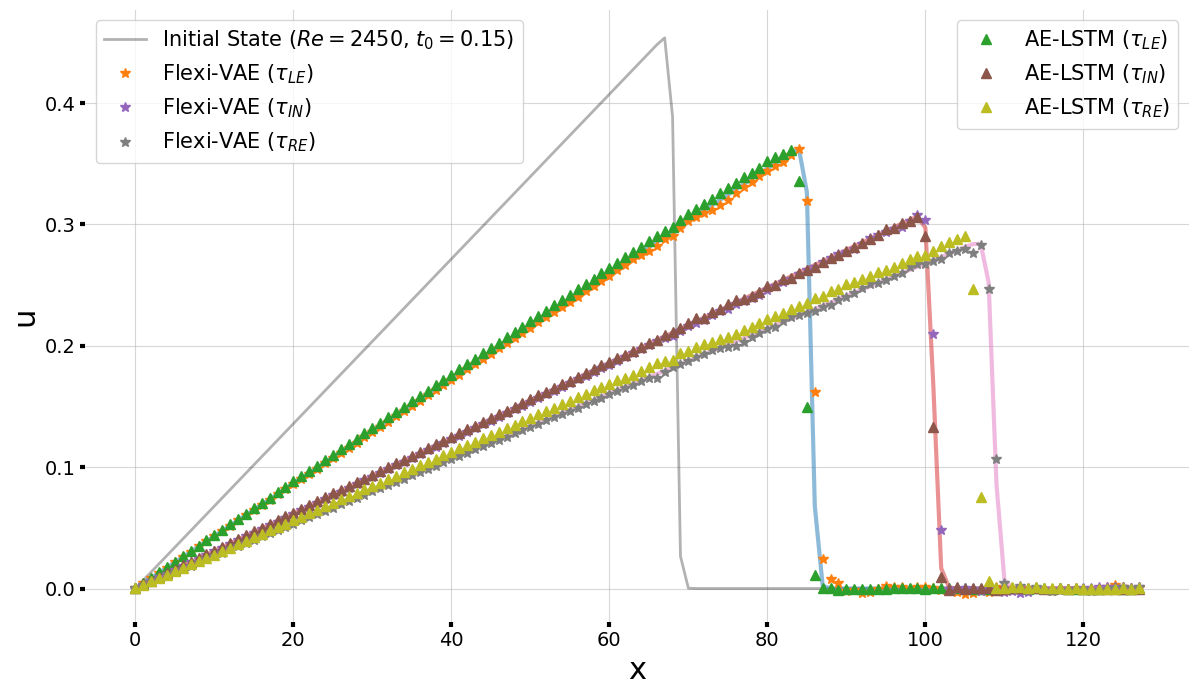

In [28]:
# Simulation setup
sim_num = -1

re_1 = rnum_vals_test[sim_num]
Re_value = re_1 * 1000
t_0 = 0.16  # Initial time
dt = 2.0 / 500.0
taus = [165, 345, 445]  # Time shifts for analysis

# Initial state
x_t = exact_solution(Re_value, t_0)
Re_tensor = torch.tensor([Re_value]).float()[:, None]
xt = torch.tensor([x_t]).float()[:, None]

# Initialize plot
plt.figure(figsize=(12, 7))

# Set axis thickness
plt.rc('axes', linewidth=2)

# Plot the initial state
plt.plot(xt.squeeze().numpy(), linewidth=2, color="black", alpha=0.30, label=r"Initial State ($Re = 2450$, $t_0 = 0.15$)")

for i, tau in enumerate(taus):
    # Calculate final time
    t_final = t_0 + tau * dt
    x_exact = exact_solution(Re_value, t_final)

    # Flexi-VAE Prediction
    tau_tensor = torch.tensor([tau]).float()[:, None]
    with torch.no_grad():
        x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, tau_tensor, Re_tensor)

    # LSTM Model Prediction
    time_shift_in_lstm = int(tau + t_0 / dt)
    elapsed_sec, pred_latent, true_latent = measure_lstm_prediction_time(
        AE_decoder, lstm_model, lstm_testing_data, sim_num, time_shift_in_lstm, time_window=40
    )
    x_hat_tau_pred = AE_decoder(torch.tensor(pred_latent, dtype=torch.float32))

    # Plot ground truth
    plt.plot(
        x_exact, linewidth=3, linestyle="-", alpha=0.5, label=f"True State (τ={tau})"
    )

    # Define legend labels for Flexi-VAE and AE-LSTM with math symbols
    if i == 0:
        flexi_label = r"Flexi-VAE ($\tau_{LE}$)"
        lstm_label = r"AE-LSTM ($\tau_{LE}$)"
    elif i == 1:
        flexi_label = r"Flexi-VAE ($\tau_{IN}$)"
        lstm_label = r"AE-LSTM ($\tau_{IN}$)"
    elif i == 2:
        flexi_label = r"Flexi-VAE ($\tau_{RE}$)"
        lstm_label = r"AE-LSTM ($\tau_{RE}$)"

    # Plot Flexi-VAE prediction
    plt.plot(
        x_hat_tau.detach().squeeze().numpy(),
        '*',
        markersize=7,
        label=flexi_label,
        alpha=1
    )

    # Plot LSTM prediction
    plt.plot(
        x_hat_tau_pred.cpu().detach().numpy(),
        '^',
        markersize=7,
        label=lstm_label,
        alpha=1
    )

# Add legend and labels
# Add legend and labels
plt.xlabel("x", fontsize=22)
plt.ylabel("u", fontsize=22)

# Collect all legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Split handles and labels into two groups
left_handles = []
left_labels = []
right_handles = []
right_labels = []

for h, l in zip(handles, labels):
    if "Initial State" in l or "Flexi-VAE" in l:
        left_handles.append(h)
        left_labels.append(l)
    elif "AE-LSTM" in l:
        right_handles.append(h)
        right_labels.append(l)

# Create two separate legends with increased font size
leg_left = plt.legend(left_handles, left_labels, loc='upper left', fontsize=15)
plt.gca().add_artist(leg_left)  # Add the left legend back after it gets removed
plt.legend(right_handles, right_labels, loc='upper right', fontsize=15)

plt.grid(alpha=0.5)
plt.tight_layout()

# Adjust axis appearance: remove the box (all spines)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14, width=3)

# Save the figure
#plt.savefig("fvae_vs_aelstm_re.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Temporal Comparison
### CPU & GPU

In [29]:
# Simulation setup
sim_num = 0  # Used to get the re from validation!

re_1 = rnum_vals_test[sim_num]
Re_value = re_1 * 1000
t_0 = 0.16  # Initial time
dt = 2.0 / 500.0

# Initial state (calculated once)
x_t = exact_solution(Re_value, t_0)
Re_tensor = torch.tensor([Re_value]).float()[:, None]
xt = torch.tensor([x_t]).float()[:, None]

taus = [150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450]

# CPU Times
vae_times = []  # Times for Flexi VAE
lstm_times = []  # Average times for LSTM
lstm_variability = []  # Variability (e.g., standard deviation)

# Run multiple trials for variability in LSTM (CPU)
for tau in taus:
    vae_time = []
    lstm_time = []
    for _ in tqdm(range(300), desc=f"Progress for tau: {tau} (CPU)"):  # Repeat for variability
        # Flexi VAE prediction
        start_time = time.time()
        with torch.no_grad():
            x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, torch.tensor([[tau]]).float(), Re_tensor)
        vae_time.append(time.time() - start_time)

        # LSTM prediction
        elapsed_sec, _, _ = measure_lstm_prediction_time(AE_decoder, lstm_model, lstm_testing_data, sim_num, tau + int(t_0 / dt), time_window=40)
        lstm_time.append(elapsed_sec)

    vae_times.append(np.mean(vae_time))
    lstm_times.append(np.mean(lstm_time))
    lstm_variability.append(np.std(lstm_time))

# GPU Times

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move initial state tensors to GPU
Re_tensor_gpu = Re_tensor.to(device)
xt_gpu = xt.to(device)

# Ensure models are on GPU
best_concat_model.to(device)
AE_decoder.to(device)
lstm_model.to(device)

vae_times_gpu = []  # Times for Flexi VAE
lstm_times_gpu = []  # Average times for LSTM
lstm_variability_gpu = []  # Variability (e.g., standard deviation)

# Run multiple trials for variability in LSTM (GPU)
for tau in taus:
    vae_time_gpu = []
    lstm_time_gpu = []
    for _ in tqdm(range(300), desc=f"Progress for tau: {tau} (GPU)"):  # Repeat for variability
        # Flexi VAE prediction
        start_time = time.time()
        with torch.no_grad():
            # Move tau tensor to GPU
            tau_tensor = torch.tensor([[tau]]).float().to(device)
            # Run model and synchronize
            x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt_gpu, tau_tensor, Re_tensor_gpu)
            torch.cuda.synchronize()  # Ensure GPU operations are complete
        vae_time_gpu.append(time.time() - start_time)

        # LSTM prediction (synchronization is handled inside the function)
        elapsed_sec, _, _ = measure_lstm_prediction_time(AE_decoder, lstm_model, lstm_testing_data, sim_num, tau + int(t_0 / dt), time_window=40)
        lstm_time_gpu.append(elapsed_sec)

    vae_times_gpu.append(np.mean(vae_time_gpu))
    lstm_times_gpu.append(np.mean(lstm_time_gpu))
    lstm_variability_gpu.append(np.std(lstm_time_gpu))

Progress for tau: 450 (CPU): 100%|████████████| 300/300 [01:10<00:00,  4.26it/s]


Using device: cuda


Progress for tau: 450 (GPU): 100%|████████████| 300/300 [00:21<00:00, 14.11it/s]


In [30]:
# Print results in a comparison format
print("tau | Flexi-VAE (CPU) | Flexi-VAE (GPU) | AE-LSTM (CPU) | AE-LSTM (GPU)")
print("-----------------------------------------------------")
for tau, vae_time_cpu, vae_time_gpu, lstm_time, lstm_time_gpu in zip(taus, vae_times, vae_times_gpu, lstm_times, lstm_times_gpu):
    print(f"{tau:4}    | {vae_time_cpu:.6f}        | {vae_time_gpu:.6f}       | {lstm_time:.6f}      | {lstm_time_gpu:.6f}")

tau | Flexi-VAE (CPU) | Flexi-VAE (GPU) | AE-LSTM (CPU) | AE-LSTM (GPU)
-----------------------------------------------------
 150    | 0.003545        | 0.000798       | 0.074414      | 0.025706
 175    | 0.003690        | 0.000736       | 0.092609      | 0.030645
 200    | 0.003705        | 0.000673       | 0.104739      | 0.032449
 225    | 0.003802        | 0.000659       | 0.116900      | 0.035143
 250    | 0.003790        | 0.000670       | 0.125876      | 0.039732
 275    | 0.003816        | 0.000648       | 0.140492      | 0.042900
 300    | 0.003633        | 0.000629       | 0.148002      | 0.046714
 325    | 0.003822        | 0.000647       | 0.167213      | 0.050539
 350    | 0.003893        | 0.000652       | 0.181005      | 0.054172
 375    | 0.003652        | 0.000737       | 0.185004      | 0.060654
 400    | 0.004183        | 0.000763       | 0.201339      | 0.070032
 425    | 0.004123        | 0.000738       | 0.223508      | 0.070753
 450    | 0.003866        | 0.0006

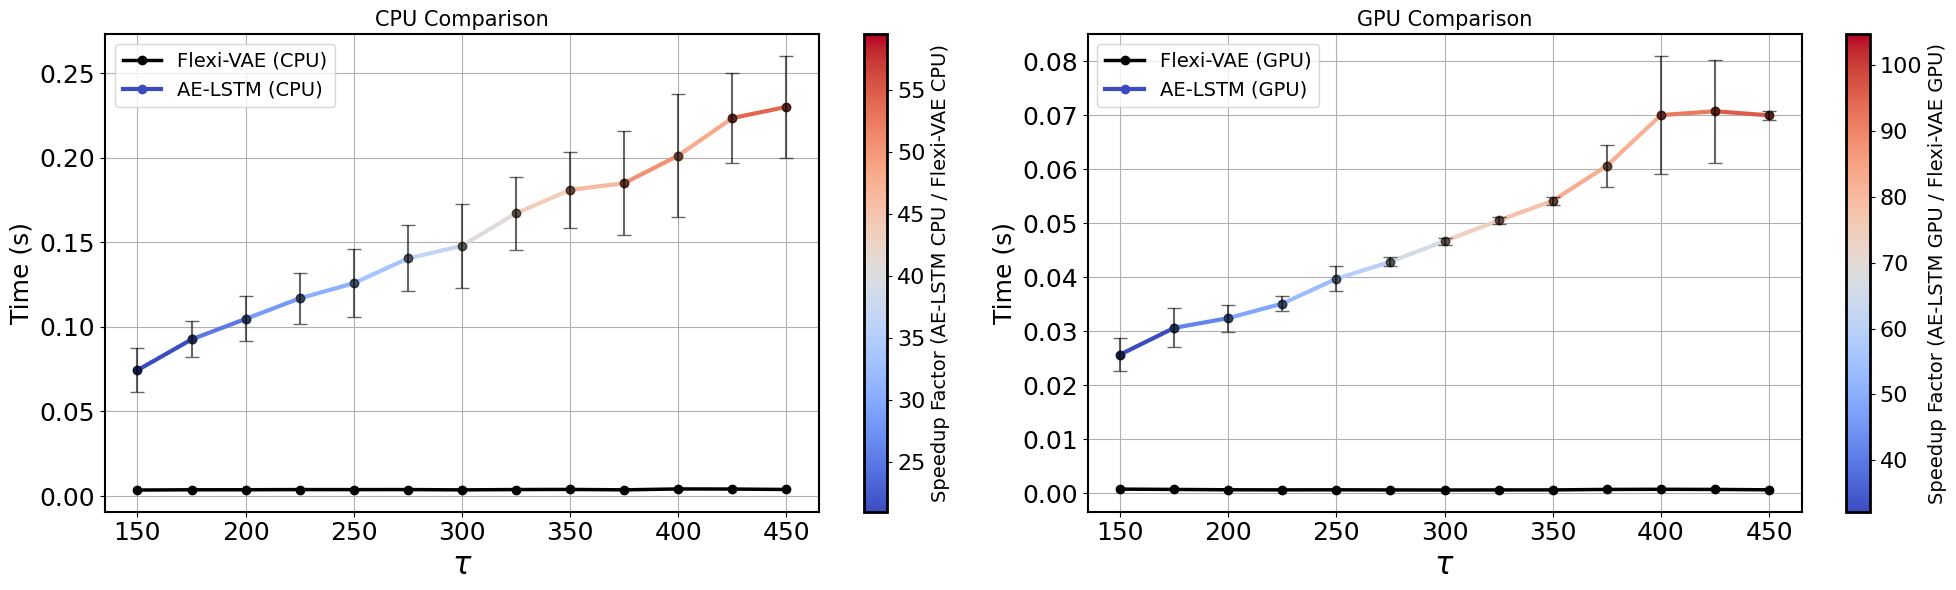

In [31]:
# Compute speedup factors
speedup_cpu = [lstm / vae for lstm, vae in zip(lstm_times, vae_times)]
speedup_gpu = [lstm / vae for lstm, vae in zip(lstm_times_gpu, vae_times_gpu)]

# Normalize speedup for colormap (separate for CPU and GPU)
norm_cpu = Normalize(vmin=min(speedup_cpu), vmax=max(speedup_cpu))
norm_gpu = Normalize(vmin=min(speedup_gpu), vmax=max(speedup_gpu))
cmap = cm.coolwarm

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Increase axis thickness for both subplots
for ax in [ax1, ax2]:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

# Subplot 1: CPU Comparison
ax1.set_title("CPU Comparison", fontsize=15)
ax1.set_xlabel(r"$\tau$", fontsize=22)
ax1.set_ylabel("Time (s)", fontsize=18)
ax1.grid()

# Increase tick font size
ax1.tick_params(axis='both', labelsize=18)

# Plot Flexi-VAE (CPU)
ax1.plot(
    taus, 
    vae_times, 
    '-o', 
    label="Flexi-VAE (CPU)", 
    linewidth=2.5, 
    color='black'
)

# Plot AE-LSTM (CPU) with colormap
for i in range(len(taus) - 1):
    ax1.plot(
        taus[i:i+2],
        lstm_times[i:i+2],
        '-o',
        color=cmap(norm_cpu(speedup_cpu[i])),
        linewidth=3.0,  # Thicker line
        label="AE-LSTM (CPU)" if i == 0 else ""
    )

# Add variability as vertical black lines with caps (CPU)
for i in range(len(taus)):
    ax1.errorbar(
        taus[i],
        lstm_times[i],
        yerr=lstm_variability[i],
        fmt='o',
        color='black',
        alpha=0.6,
        capsize=5  # Add horizontal caps at the ends
    )

# Add colorbar for CPU speedup
sm_cpu = ScalarMappable(cmap=cmap, norm=norm_cpu)
sm_cpu.set_array([])
cbar_cpu = fig.colorbar(sm_cpu, ax=ax1)
cbar_cpu.set_label("Speedup Factor (AE-LSTM CPU / Flexi-VAE CPU)", fontsize=14)

# Increase colorbar tick font size
cbar_cpu.ax.tick_params(labelsize=16)

# Subplot 2: GPU Comparison
ax2.set_title("GPU Comparison", fontsize=15)
ax2.set_xlabel(r"$\tau$", fontsize=22)
ax2.set_ylabel("Time (s)", fontsize=18)
ax2.grid()

# Increase tick font size
ax2.tick_params(axis='both', labelsize=18)

# Plot Flexi-VAE (GPU)
ax2.plot(
    taus, 
    vae_times_gpu, 
    '-o', 
    label="Flexi-VAE (GPU)", 
    linewidth=2.5, 
    color='black'
)

# Plot AE-LSTM (GPU) with colormap
for i in range(len(taus) - 1):
    ax2.plot(
        taus[i:i+2],
        lstm_times_gpu[i:i+2],
        '-o',
        color=cmap(norm_gpu(speedup_gpu[i])),
        linewidth=3.0,  # Thicker line
        label="AE-LSTM (GPU)" if i == 0 else ""
    )

# Add variability as vertical black lines with caps (GPU)
for i in range(len(taus)):
    ax2.errorbar(
        taus[i],
        lstm_times_gpu[i],
        yerr=lstm_variability_gpu[i],
        fmt='o',
        color='black',
        alpha=0.6,
        capsize=5  # Add horizontal caps at the ends
    )

# Add colorbar for GPU speedup
sm_gpu = ScalarMappable(cmap=cmap, norm=norm_gpu)
sm_gpu.set_array([])
cbar_gpu = fig.colorbar(sm_gpu, ax=ax2)
cbar_gpu.set_label("Speedup Factor (AE-LSTM GPU / Flexi-VAE GPU)", fontsize=14)

# Increase colorbar tick font size
cbar_gpu.ax.tick_params(labelsize=16)

# Add legends with increased font size
ax1.legend(loc="upper left", prop={'size': 14})
ax2.legend(loc="upper left", prop={'size': 14})

plt.tight_layout()

# Save the figure
#plt.savefig("CPU_GPU_Comparison.png", dpi=300, bbox_inches='tight')

plt.show()

# Overall Model Comparisons - Viscous Burgers

In [32]:
from model_v2 import Encoder, Decoder, Propagator_concat as Propagator_C, Propagator_encoding as Propagator_E, Model, loss_function

# Loading paths of all the 6 best models -

# 1K - concat
one_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/1k_concat/checkpoints/FlexiPropagator_2025-02-16-18-30-42_340d4ecc_best.pt"

# 3K - concat
three_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/3k_concat/checkpoints/FlexiPropagator_2025-02-15-23-34-43_76e2bd89_best.pt"

# 5K - concat
five_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/5k_concat/checkpoints/FlexiPropagator_2025-02-16-18-44-25_f64eb372_best.pt"

# 7K - concat
seven_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/7k_concat/checkpoints/FlexiPropagator_2025-02-16-09-09-35_c31a7d0d_best.pt"

# 10K - concat -HDE
ten_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/10k_samples/FlexiProp_Concat_Burgers/checkpoints/FlexiPropagator_2025-02-02-13-07-47_4bfbb352_best.pt"
ten_K_HDE_model_path    = "/home/krafiq/Desktop/Flexi Propagator 1D/10k_samples/FlexiProp_HDE_Burgers/checkpoints/FlexiPropagator_2025-02-02-10-38-46_45631673_best.pt"

# 20k - concat - HDE
twenty_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/20k_samples/FlexiProp_Concat_Burgers/checkpoints/FlexiPropagator_2025-01-31-21-15-07_28928994_best.pt"
twenty_K_HDE_model_path    = "/home/krafiq/Desktop/Flexi Propagator 1D/20k_samples/FlexiProp_HDE_Burgers/checkpoints/FlexiPropagator_2025-01-31-19-52-18_d7fb05c6_best.pt"

# 40k - concat - HDE
fourty_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/40k_samples/FlexiProp_concat_Burgers/checkpoints/FlexiPropagator_2025-01-30-06-36-01_318b9c89_best.pt"
fourty_K_HDE_model_path    = "/home/krafiq/Desktop/Flexi Propagator 1D/40k_samples/FlexiProp_HDE_Burgers/checkpoints/FlexiPropagator_2025-02-01-10-43-52_a0a18449_best.pt"

# 80k - concat - HDE
eighty_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/80k_samples/FlexiProp_Concat_Burgers/checkpoints/FlexiPropagator_2025-02-01-10-28-34_3e9656b5_best.pt"
eighty_K_HDE_model_path    = "/home/krafiq/Desktop/Flexi Propagator 1D/80k_samples/FlexiProp_HDE_Burgers/checkpoints/FlexiPropagator_2025-02-01-04-31-51_431b6c0b_best.pt"

# 120k - concat - HDE
hundred_twenty_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/120k_samples/FlexiProp_Concat_Burgers/checkpoints/FlexiPropagator_2025-02-04-09-56-49_0ed23064_best.pt"
hundred_twenty_K_HDE_model_path    = "/home/krafiq/Desktop/Flexi Propagator 1D/120k_samples/FlexiProp_HDE_Burgers/checkpoints/FlexiPropagator_2025-02-03-15-24-27_53cc66c1_best.pt"


def get_model(input_dim, latent_dim, Propagator):
    # Instantiate encoder, decoder, and model
    encoder = Encoder(input_dim, latent_dim)
    decoder = Decoder(latent_dim, input_dim)  # Decoder for x(t)
    propagator = Propagator(latent_dim)  # z(t) --> z(t+tau)
    model = Model(encoder, decoder, propagator)
    return model

def load_model_weights(model, checkpoint_path):
    """
    Loads the checkpoint from the given path, extracts the model_state_dict
    (if it exists), and loads it into the model using strict=False.
    """
    if not os.path.isfile(checkpoint_path):
        print(f"Checkpoint file not found at path: {checkpoint_path}")
        return model
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    except Exception as e:
        print(f"Error loading checkpoint from {checkpoint_path}: {e}")
        return model
    
    # If the checkpoint has a key "model_state_dict", extract it.
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

# Instantiate the template models (not used for loading but can serve as a reference)
concat_model_template = get_model(128, 2, Propagator_C)
HDE_model_template    = get_model(128, 2, Propagator_E)

# 1k models
one_K_concat_model = get_model(128, 2, Propagator_C)
one_K_concat_model = load_model_weights(one_K_concat_model, one_K_concat_model_path)

# 3k models
three_K_concat_model = get_model(128, 2, Propagator_C)
three_K_concat_model = load_model_weights(three_K_concat_model, three_K_concat_model_path)

# 5k models
five_K_concat_model = get_model(128, 2, Propagator_C)
five_K_concat_model = load_model_weights(five_K_concat_model, five_K_concat_model_path)

# 7k models
seven_K_concat_model = get_model(128, 2, Propagator_C)
seven_K_concat_model = load_model_weights(seven_K_concat_model, seven_K_concat_model_path)

# 10k models
ten_K_concat_model = get_model(128, 2, Propagator_C)
ten_K_concat_model = load_model_weights(ten_K_concat_model, ten_K_concat_model_path)

ten_K_HDE_model = get_model(128, 2, Propagator_E)
ten_K_HDE_model = load_model_weights(ten_K_HDE_model, ten_K_HDE_model_path)

# 20k models
twenty_K_concat_model = get_model(128, 2, Propagator_C)
twenty_K_concat_model = load_model_weights(twenty_K_concat_model, twenty_K_concat_model_path)

twenty_K_HDE_model = get_model(128, 2, Propagator_E)
twenty_K_HDE_model = load_model_weights(twenty_K_HDE_model, twenty_K_HDE_model_path)

# 40k models
fourty_K_concat_model = get_model(128, 2, Propagator_C)
fourty_K_concat_model = load_model_weights(fourty_K_concat_model, fourty_K_concat_model_path)

fourty_K_HDE_model = get_model(128, 2, Propagator_E)
fourty_K_HDE_model = load_model_weights(fourty_K_HDE_model, fourty_K_HDE_model_path)

# 80k models
eighty_K_concat_model = get_model(128, 2, Propagator_C)
eighty_K_concat_model = load_model_weights(eighty_K_concat_model, eighty_K_concat_model_path)

eighty_K_HDE_model = get_model(128, 2, Propagator_E)
eighty_K_HDE_model = load_model_weights(eighty_K_HDE_model, eighty_K_HDE_model_path)

# 120k models
hundred_twenty_K_concat_model = get_model(128, 2, Propagator_C)
hundred_twenty_K_concat_model = load_model_weights(hundred_twenty_K_concat_model, hundred_twenty_K_concat_model_path)

hundred_twenty_K_HDE_model = get_model(128, 2, Propagator_E)
hundred_twenty_K_HDE_model = load_model_weights(hundred_twenty_K_HDE_model, hundred_twenty_K_HDE_model_path)


# loading the intervals - 
data_path = "./data"
_, _, re_interval_split, tau_interval_split = load_from_path(data_path)

# Interval Split
print("Re Interval Split", re_interval_split)
print()
print("Tau Interval Split", tau_interval_split)

Re Interval Split IntervalSplit(interpolation=[822.0727212912974, 1022.0727212912974], extrapolation_left=[400, 600.0], extrapolation_right=[2200.0, 2400])

Tau Interval Split IntervalSplit(interpolation=[340.3940583106784, 367.8940583106784], extrapolation_left=[150, 177.5], extrapolation_right=[397.5, 425])


In [33]:
# --- EXPERIMENT PARAMETERS ---
num_samples = 3000      # Number of random (Re, tau) combinations to test
dt = 2.0 / 500.0        # Time step scale factor
t0_list = [0.20, 0.40, 0.60, 0.80, 1.0, 1.25, 1.5]  # List of initial times to average over

# Prepare lists to store MSE errors for each model:
errors_1k_concat = []
errors_3k_concat = []
errors_5k_concat = []
errors_7k_concat = []
errors_10k_concat = []
errors_20k_concat = []
errors_40k_concat = []
errors_80k_concat = []
errors_120k_concat = []

errors_10k_HDE    = []
errors_20k_HDE    = []
errors_40k_HDE    = []
errors_80k_HDE    = []
errors_120k_HDE    = []

# --- LOOP OVER RANDOM SAMPLES ---
for i in tqdm(range(num_samples), desc ="Sampling Status"):
    # Randomly choose the extrapolation zone for Re and tau
    re_zone  = np.random.choice(["extrapolation_left", "extrapolation_right"])
    tau_zone = np.random.choice(["extrapolation_left", "extrapolation_right"])
    
    # Use getattr to fetch the corresponding interval from the split objects
    Re_value = np.random.uniform(*getattr(re_interval_split, re_zone))
    tau_val  = np.random.uniform(*getattr(tau_interval_split, tau_zone))
    
    # We'll accumulate error over the different t0 values for this (Re, tau) pair:
    err_1k_concat_sample = 0
    err_3k_concat_sample = 0
    err_5k_concat_sample = 0
    err_7k_concat_sample = 0
    err_10k_concat_sample = 0
    err_20k_concat_sample = 0
    err_40k_concat_sample = 0
    err_80k_concat_sample = 0
    err_120k_concat_sample = 0

    err_4k_HDE_sample    = 0
    err_10k_HDE_sample    = 0
    err_20k_HDE_sample    = 0
    err_40k_HDE_sample    = 0
    err_80k_HDE_sample    = 0
    err_120k_HDE_sample    = 0
    
    for t0 in t0_list:
        # --- Compute the initial and exact final state for this t0 ---
        x_t = exact_solution(Re_value, t0)           # Initial state (x_t)
        t_final = t0 + tau_val * dt                   # Final time corresponding to the sampled tau
        x_exact = exact_solution(Re_value, t_final)    # Exact final state

        # --- Convert inputs to torch tensors ---
        xt = torch.tensor([x_t]).float()[:, None]      # Shape: (1, 128)
        tau_tensor = torch.tensor([tau_val]).float()[:, None]  # Shape: (1, 1)
        Re_tensor  = torch.tensor([Re_value]).float()[:, None] # Shape: (1, 1)
        
        # --- Run each model to predict the future state ---
        with torch.no_grad():
            # For the 1k Concat model:
            _, x_hat_tau_1k_concat, _, _, _ = one_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 3k Concat model:
            _, x_hat_tau_3k_concat, _, _, _ = three_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 5k Concat model:
            _, x_hat_tau_5k_concat, _, _, _ = five_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 7k Concat model:
            _, x_hat_tau_7k_concat, _, _, _ = seven_K_concat_model(xt, tau_tensor, Re_tensor)           
            # For the 10k Concat model:
            _, x_hat_tau_10k_concat, _, _, _ = ten_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 20k Concat model:
            _, x_hat_tau_20k_concat, _, _, _ = twenty_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 40k Concat model:
            _, x_hat_tau_40k_concat, _, _, _ = fourty_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 80k Concat model:
            _, x_hat_tau_80k_concat, _, _, _ = eighty_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 120k Concat model:
            _, x_hat_tau_120k_concat, _, _, _ = hundred_twenty_K_concat_model(xt, tau_tensor, Re_tensor)

            # For the 10k HDE model:
            _, x_hat_tau_10k_HDE, _, _, _ = ten_K_HDE_model(xt, tau_tensor, Re_tensor)
            # For the 20k HDE model:
            _, x_hat_tau_20k_HDE, _, _, _ = twenty_K_HDE_model(xt, tau_tensor, Re_tensor)
            # For the 40k HDE model:
            _, x_hat_tau_40k_HDE, _, _, _ = fourty_K_HDE_model(xt, tau_tensor, Re_tensor)
            # For the 80k HDE model:
            _, x_hat_tau_80k_HDE, _, _, _ = eighty_K_HDE_model(xt, tau_tensor, Re_tensor)
            # For the 120k HDE model:
            _, x_hat_tau_120k_HDE, _, _, _ = hundred_twenty_K_HDE_model(xt, tau_tensor, Re_tensor)
        
        # --- Compute MSE for each model for this t0 ---
        mse_1k_concat = np.mean((x_hat_tau_1k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_3k_concat = np.mean((x_hat_tau_3k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_5k_concat = np.mean((x_hat_tau_5k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_7k_concat = np.mean((x_hat_tau_7k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_10k_concat = np.mean((x_hat_tau_10k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_20k_concat = np.mean((x_hat_tau_20k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_40k_concat = np.mean((x_hat_tau_40k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_80k_concat = np.mean((x_hat_tau_80k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_120k_concat = np.mean((x_hat_tau_120k_concat.squeeze().cpu().numpy() - x_exact)**2)

        mse_10k_HDE    = np.mean((x_hat_tau_10k_HDE.squeeze().cpu().numpy()    - x_exact)**2)
        mse_20k_HDE    = np.mean((x_hat_tau_20k_HDE.squeeze().cpu().numpy()    - x_exact)**2)
        mse_40k_HDE    = np.mean((x_hat_tau_40k_HDE.squeeze().cpu().numpy()    - x_exact)**2)
        mse_80k_HDE    = np.mean((x_hat_tau_80k_HDE.squeeze().cpu().numpy()    - x_exact)**2)
        mse_120k_HDE    = np.mean((x_hat_tau_120k_HDE.squeeze().cpu().numpy()    - x_exact)**2)
        
        # Accumulate the error over t0 values
        err_1k_concat_sample += mse_1k_concat
        err_3k_concat_sample += mse_3k_concat
        err_5k_concat_sample += mse_5k_concat
        err_7k_concat_sample += mse_7k_concat
        err_10k_concat_sample += mse_10k_concat
        err_20k_concat_sample += mse_20k_concat
        err_40k_concat_sample += mse_40k_concat
        err_80k_concat_sample += mse_80k_concat
        err_120k_concat_sample += mse_120k_concat

        err_10k_HDE_sample    += mse_10k_HDE
        err_20k_HDE_sample    += mse_20k_HDE
        err_40k_HDE_sample    += mse_40k_HDE
        err_80k_HDE_sample    += mse_80k_HDE
        err_120k_HDE_sample    += mse_120k_HDE

    # Average the error for this sample over the different t0 values
    num_t0 = len(t0_list)
    errors_1k_concat.append(err_1k_concat_sample / num_t0)
    errors_3k_concat.append(err_3k_concat_sample / num_t0)
    errors_5k_concat.append(err_5k_concat_sample / num_t0)
    errors_7k_concat.append(err_7k_concat_sample / num_t0)
    errors_10k_concat.append(err_10k_concat_sample / num_t0)
    errors_20k_concat.append(err_20k_concat_sample / num_t0)
    errors_40k_concat.append(err_40k_concat_sample / num_t0)
    errors_80k_concat.append(err_80k_concat_sample / num_t0)
    errors_120k_concat.append(err_120k_concat_sample / num_t0)

    errors_10k_HDE.append(err_10k_HDE_sample / num_t0)
    errors_20k_HDE.append(err_20k_HDE_sample / num_t0)
    errors_40k_HDE.append(err_40k_HDE_sample / num_t0)
    errors_80k_HDE.append(err_80k_HDE_sample / num_t0)
    errors_120k_HDE.append(err_120k_HDE_sample / num_t0)

# --- Compute Average MSE for Each Model Over All Samples ---
avg_1k_concat = np.mean(errors_1k_concat)
avg_3k_concat = np.mean(errors_3k_concat)
avg_5k_concat = np.mean(errors_5k_concat)
avg_7k_concat = np.mean(errors_7k_concat)
avg_10k_concat = np.mean(errors_10k_concat)
avg_20k_concat = np.mean(errors_20k_concat)
avg_40k_concat = np.mean(errors_40k_concat)
avg_80k_concat = np.mean(errors_80k_concat)
avg_120k_concat = np.mean(errors_120k_concat)

avg_10k_HDE    = np.mean(errors_10k_HDE)
avg_20k_HDE    = np.mean(errors_20k_HDE)
avg_40k_HDE    = np.mean(errors_40k_HDE)
avg_80k_HDE    = np.mean(errors_80k_HDE)
avg_120k_HDE    = np.mean(errors_120k_HDE)

print("Average MSE Errors over {} samples (averaged over t0 values):".format(num_samples))
print(f"1k Concat: {avg_1k_concat:.4e}")
print(f"3k Concat: {avg_3k_concat:.4e}")
print(f"5k Concat: {avg_5k_concat:.4e}")
print(f"7k Concat: {avg_7k_concat:.4e}")
print(f"10k Concat: {avg_10k_concat:.4e}")
print(f"20k Concat: {avg_20k_concat:.4e}")
print(f"40k Concat: {avg_40k_concat:.4e}")
print(f"80k Concat: {avg_80k_concat:.4e}")
print(f"120k Concat: {avg_120k_concat:.4e}")

print(f"10k HDE:    {avg_10k_HDE:.4e}")
print(f"20k HDE:    {avg_20k_HDE:.4e}")
print(f"40k HDE:    {avg_40k_HDE:.4e}")
print(f"80k HDE:    {avg_80k_HDE:.4e}")
print(f"120k HDE:    {avg_120k_HDE:.4e}")

Sampling Status: 100%|██████████████████████| 3000/3000 [20:27<00:00,  2.44it/s]

Average MSE Errors over 3000 samples (averaged over t0 values):
1k Concat: 1.0952e-03
3k Concat: 2.1444e-04
5k Concat: 1.7271e-04
7k Concat: 1.7471e-04
10k Concat: 1.3516e-04
20k Concat: 1.0397e-04
40k Concat: 6.6309e-05
80k Concat: 3.4922e-05
120k Concat: 7.4974e-05
10k HDE:    6.7714e-04
20k HDE:    4.4750e-04
40k HDE:    7.0427e-04
80k HDE:    5.4558e-04
120k HDE:    6.6877e-04


Slope of the sweet spot region: -0.5764


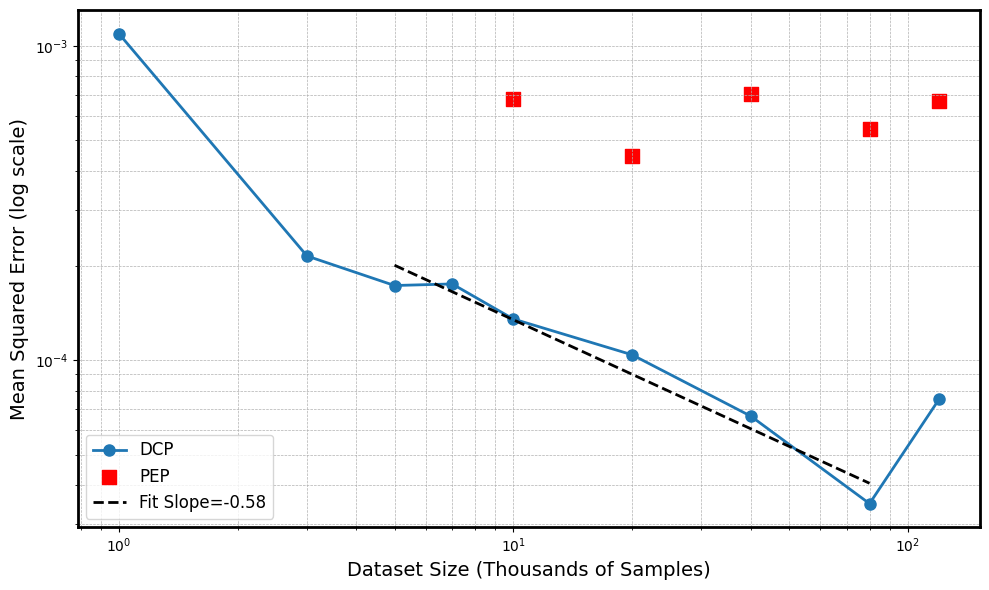

In [34]:
from scipy.stats import linregress

# Sample sizes in thousands
concat_sample_sizes = np.array([1, 3, 5, 7, 10, 20, 40, 80, 120])
hde_sample_sizes    = np.array([10, 20, 40, 80, 120])
# Create arrays for plotting
concat_errors = np.array([avg_1k_concat, avg_3k_concat, avg_5k_concat, avg_7k_concat, 
                 avg_10k_concat, avg_20k_concat, avg_40k_concat, avg_80k_concat, avg_120k_concat])

hde_errors    = np.array([avg_10k_HDE, avg_20k_HDE, avg_40k_HDE, avg_80k_HDE, avg_120k_HDE])

# ---- Sweet spot fit (from 3rd point to second-last point) ---- #
sweet_start_idx = 2  # 3rd point
sweet_end_idx   = -2 # second-last point

# Get sweet spot data
x_sweet = concat_sample_sizes[sweet_start_idx:sweet_end_idx+1]
y_sweet = concat_errors[sweet_start_idx:sweet_end_idx+1]

# Perform linear regression on log-log data
log_x = np.log10(x_sweet)
log_y = np.log10(y_sweet)
slope, intercept, _, _, _ = linregress(log_x, log_y)

# Generate the fitted line (back in linear space)
fit_line_x = np.linspace(log_x[0], log_x[-1], 100)
fit_line_y = slope * fit_line_x + intercept

# ---- Plotting ---- #
plt.figure(figsize=(10, 6))

# Plot the Concat model results with solid line + markers
plt.plot(concat_sample_sizes, concat_errors, marker='o', linestyle='-', linewidth=2, markersize=8, label='DCP')

# Plot the HDE model results with scatter (no line)
plt.scatter(hde_sample_sizes, hde_errors, color='red', marker='s', s=100, label='PEP')

# Plot the sweet spot slope fit line (black dotted)
plt.plot(10**fit_line_x, 10**fit_line_y, 'k--', linewidth=2, label=f'Fit Slope={slope:.2f}')

# Set the Y-axis to log scale
plt.yscale('log')
plt.xscale('log')

# Labels and title
plt.xlabel('Dataset Size (Thousands of Samples)', fontsize=14)
plt.ylabel('Mean Squared Error (log scale)', fontsize=14)
#plt.title('Prediction Error vs. Dataset Size', fontsize=16)

# Grid for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Legend
plt.legend(fontsize=12)

# Tight layout for clean spacing
plt.tight_layout()

# Show the slope in the terminal
print(f"Slope of the sweet spot region: {slope:.4f}")
#plt.savefig("log_loss_dcp_pep")
# Show the plot
plt.show()


## Physical Intrepretability of Parametric propagated latent

In [35]:
# Parameters
TRANGE = (0, 2)
Re_value = torch.tensor([2200], dtype=torch.float32)  # Interpolation Re value
t0 = 0.10  # Initial time
dt = 2.0 / 500.0
taus = torch.arange(175, 425, dtype=torch.float32).unsqueeze(-1)  # Shape: (250, 1)

# Generate initial state x_t
x_t = torch.tensor(exact_solution(Re_value.item(), t0)[None, None, :], dtype=torch.float32)

In [36]:
# # Define five different Reynolds numbers (now 9 to match your Re_values)

# Re_values = torch.tensor([500, 900, 1300, 1700, 2100, 2300], dtype=torch.float32)

# # Expand markers and colors to match 9 Re_values
# markers = ['o', 's', '^', 'D', 'P', '*']  # 6 distinct markers
# colors = plt.cm.tab10(np.linspace(0, 1, 6))  # 9 distinct colors from colormap

# # Create figure with 2 subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
# cmap = plt.get_cmap('jet')

# # Process both models
# for ax, model, model_name in [(ax1, hundred_twenty_K_concat_model, "Concatenation Model"), 
#                               (ax2, hundred_twenty_K_HDE_model, "HDE Model")]:
    
#     for i, Re_value in enumerate(Re_values):
#         x_t = torch.tensor(exact_solution(Re_value.item(), t0)[None, None, :], dtype=torch.float32)

#         # Lists to store results for current Re and model
#         z_taus = []
        
#         # Propagate latents
#         for tau in taus:
#             with torch.no_grad():
#                 _, x_hat_tau, mean, log_var, z_tau = model(
#                     x_t, 
#                     tau.view(1, 1), 
#                     Re_value.view(1, 1)
#                 )
#             z_taus.append(z_tau.squeeze(0))

#         # Compute physical times and get exact solutions
#         physical_times = t0 + taus.squeeze(-1).numpy() * dt
#         exact_solns = torch.stack([
#             torch.tensor(exact_solution(Re_value.item(), t), dtype=torch.float32) 
#             for t in physical_times
#         ])
        
#         # Get latents from exact solutions
#         with torch.no_grad():
#             means_from_exact = torch.stack([
#                 model.encoder(exact_sol.unsqueeze(0).unsqueeze(0))[0].squeeze(0)
#                 for exact_sol in exact_solns
#             ])

#         # Convert to numpy arrays
#         actual_means = means_from_exact.numpy().squeeze()
#         propagated_means = torch.stack(z_taus).numpy().squeeze()
        
#         # Plotting with unique markers/colors for each Re
#         ax.scatter(
#             actual_means[:, 0], actual_means[:, 1],
#             color=colors[i], 
#             marker=markers[i],
#             label=f'Actual (Re={Re_value.item()})', 
#             alpha=0.7,
#             s=40  # Increased marker size
#         )
        
#         sc = ax.scatter(
#             propagated_means[:, 0], propagated_means[:, 1],
#             c=taus.numpy().squeeze(), 
#             cmap=cmap, 
#             marker=markers[i],
#             edgecolor=colors[i],
#             linewidth=0.5,
#             alpha=0.7,
#             label=f'Propagated (Re={Re_value.item()})'
#         )

#     # Formatting
#     ax.set_title(model_name, fontsize=16)
#     ax.set_xlabel(r'$Z_1$', fontsize=14)
#     ax.set_ylabel(r'$Z_2$', fontsize=14)
#     ax.tick_params(axis='both', which='major', labelsize=12)
#     ax.grid(alpha=0.3)
    
#     # Add colorbar
#     cbar = fig.colorbar(sc, ax=ax)
#     cbar.set_label('Tau alues', fontsize=12)
    
#     # Improved legend
#     ax.legend(fontsize=9, loc='upper right', ncol=2)

# # Final formatting
# plt.suptitle("Latent Space Comparison Across Reynolds Numbers", fontsize=18, y=1.02)
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.25)  # Add space between subplots
# plt.show()

#### 10K Model - Concat Vs HDE

In [37]:
# # Define the latent space sampling grid
# z1_vals = np.linspace(10, 20, 500)
# z2_vals = np.linspace(1, 10, 500)
# Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
# latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# # Convert to tensor for decoding
# latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# # Decode the latent vectors
# with torch.no_grad():
#     decoded_signals = ten_K_concat_model.decoder(latent_tensors)

# # Compute sharpness and peak location
# sharpness = []
# peak_positions = []

# x_vals = np.linspace(0, 2, decoded_signals.shape[1])
# dx = x_vals[1] - x_vals[0]

# for signal in decoded_signals.numpy():
#     grad_u = np.gradient(signal, dx)  # Compute spatial gradient
#     sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
#     peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

# sharpness = np.array(sharpness).reshape(Z1.shape)
# peak_positions = np.array(peak_positions).reshape(Z1.shape)

# # Create figure and axes
# fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# # Sharpness Plot (Left)
# c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
# axes[0].set_ylabel("$Z_2$", fontsize=14)
# axes[0].set_title("Sharpness Encoding", fontsize=14)

# # Peak Position Plot (Right)
# c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
# axes[1].set_title("Peak Position Encoding", fontsize=14)

# # Remove redundant y-axis labels on the second plot for better aesthetics
# axes[1].set_yticklabels([])

# # Set a single x-axis label centered below both plots
# fig.supxlabel("$Z_1$", fontsize=14)

# # Move colorbar for sharpness encoding to **right of the first plot**
# cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
# cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)
# plt.savefig("10K_Concat")
# plt.show()


In [38]:
# # Define the latent space sampling grid
# z1_vals = np.linspace(-0.5, 2.5, 500)
# z2_vals = np.linspace(0, 1, 500)
# Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
# latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# # Convert to tensor for decoding
# latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# # Decode the latent vectors
# with torch.no_grad():
#     decoded_signals = ten_K_HDE_model.decoder(latent_tensors)

# # Compute sharpness and peak location
# sharpness = []
# peak_positions = []

# x_vals = np.linspace(0, 2, decoded_signals.shape[1])
# dx = x_vals[1] - x_vals[0]

# for signal in decoded_signals.numpy():
#     grad_u = np.gradient(signal, dx)  # Compute spatial gradient
#     sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
#     peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

# sharpness = np.array(sharpness).reshape(Z1.shape)
# peak_positions = np.array(peak_positions).reshape(Z1.shape)

# # Create figure and axes
# fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# # Sharpness Plot (Left)
# c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
# axes[0].set_ylabel("$Z_2$", fontsize=14)
# axes[0].set_title("Sharpness Encoding", fontsize=14)

# # Peak Position Plot (Right)
# c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
# axes[1].set_title("Peak Position Encoding", fontsize=14)

# # Remove redundant y-axis labels on the second plot for better aesthetics
# axes[1].set_yticklabels([])

# # Set a single x-axis label centered below both plots
# fig.supxlabel("$Z_1$", fontsize=14)

# # Move colorbar for sharpness encoding to **right of the first plot**
# cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
# cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)

# plt.savefig("10K_HDE")
# plt.show()


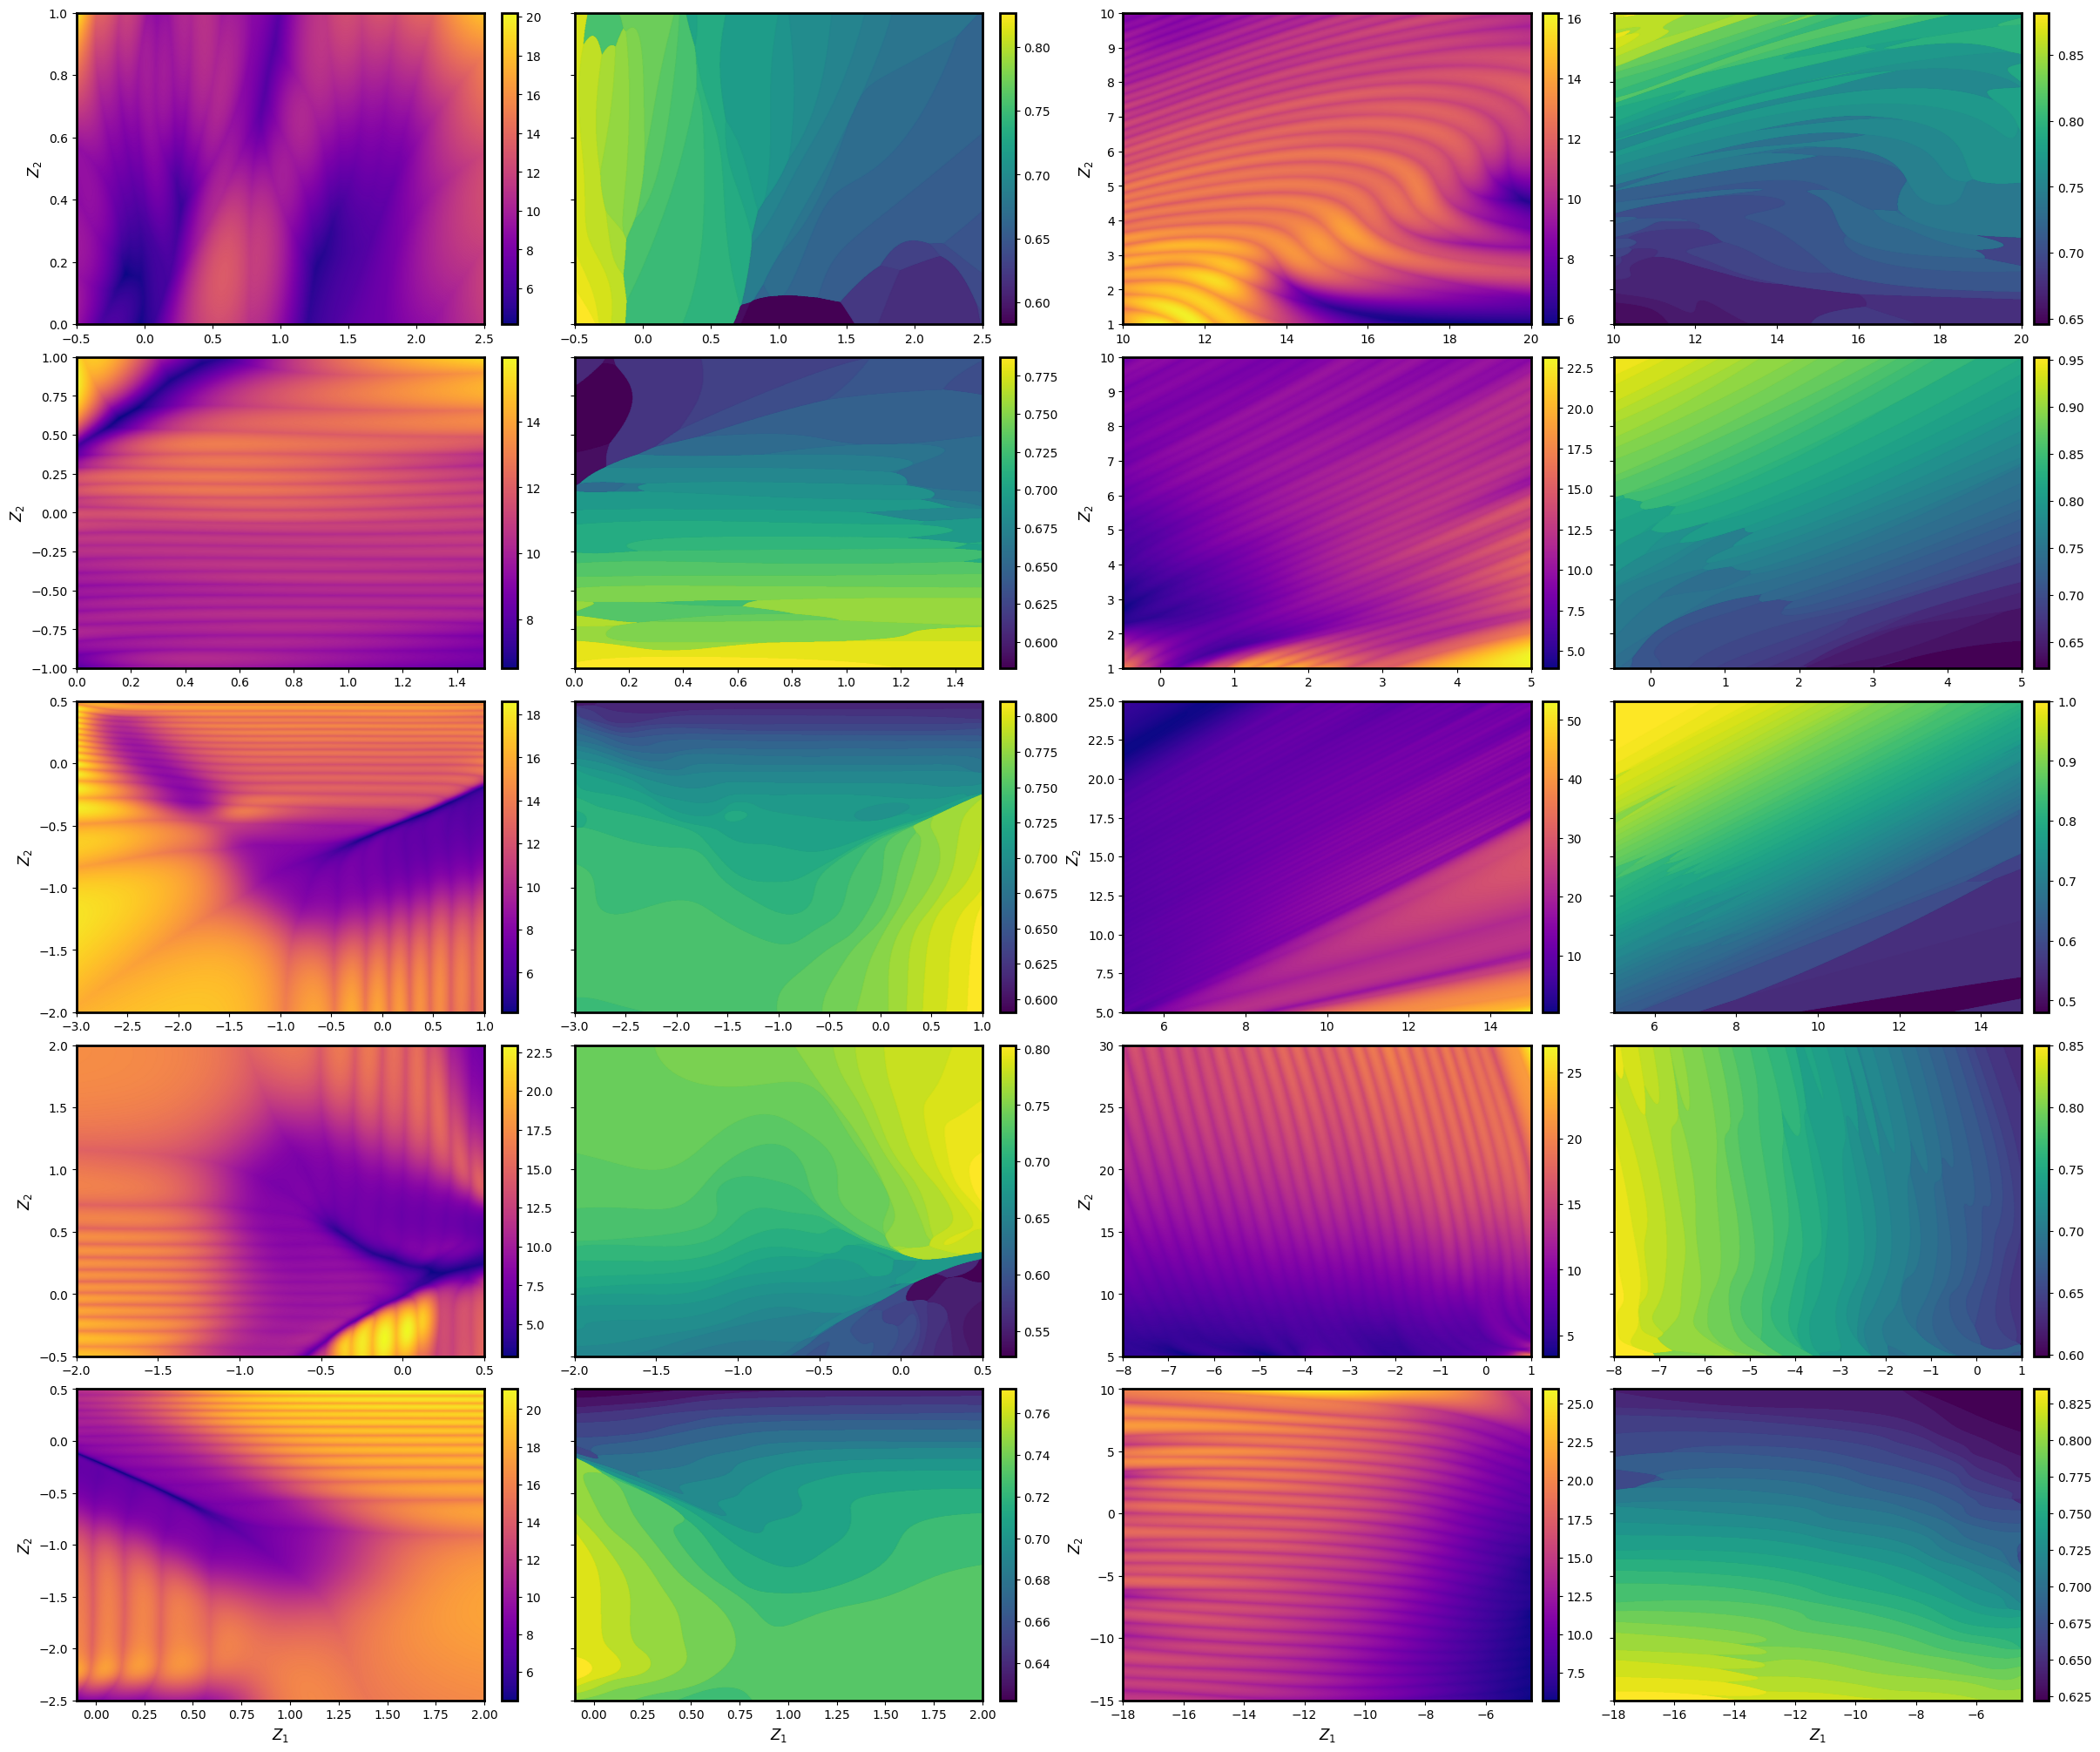

In [39]:
# Define the models and their corresponding latent space sampling grids
quality = 1000  # Set the resolution of the meshgrid
models = [
    ("10K_PEP", ten_K_HDE_model, np.linspace(-0.5, 2.5, quality), np.linspace(0, 1, quality)),
    ("10K_DCP", ten_K_concat_model, np.linspace(10, 20, quality), np.linspace(1, 10, quality)),
    ("20K_PEP", twenty_K_HDE_model, np.linspace(0, 1.5, quality), np.linspace(-1, 1, quality)),
    ("20K_DCP", twenty_K_concat_model, np.linspace(-0.5, 5, quality), np.linspace(1, 10, quality)),
    ("40K_PEP", fourty_K_HDE_model, np.linspace(-3, 1, quality), np.linspace(-2, 0.5, quality)),
    ("40K_DCP", fourty_K_concat_model, np.linspace(5, 15, quality), np.linspace(5, 25, quality)),
    ("80K_PEP", eighty_K_HDE_model, np.linspace(-2, 0.5, quality), np.linspace(-0.5, 2, quality)),
    ("80K_DCP", eighty_K_concat_model, np.linspace(-8, 1, quality), np.linspace(5, 30, quality)),
    ("120K_PEP", hundred_twenty_K_HDE_model, np.linspace(-0.1, 2, quality), np.linspace(-2.5, 0.5, quality)),
    ("120K_DCP", hundred_twenty_K_concat_model, np.linspace(-18, -4.5, quality), np.linspace(-15, 10, quality))
]

# Create a figure with subplots
fig, axes = plt.subplots(5, 4, figsize=(24, 20), constrained_layout=True, gridspec_kw={'wspace': 0, 'hspace': 0.01})

# Loop through each model and plot the results
for i in range(5):  # 5 rows for 10K, 20K, ..., 120K
    for j in range(2):  # 2 columns for PEP and DCP
        model_name, model, z1_vals, z2_vals = models[2 * i + j]
        Z1, Z2 = np.meshgrid(z1_vals, z2_vals)
        latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)
        latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

        with torch.no_grad():
            decoded_signals = model.decoder(latent_tensors)

        sharpness = []
        peak_positions = []

        x_vals = np.linspace(0, 1, decoded_signals.shape[1])
        dx = x_vals[1] - x_vals[0]

        for signal in decoded_signals.numpy():
            grad_u = np.gradient(signal, dx)
            sharpness.append(np.max(np.abs(grad_u)))
            peak_positions.append(x_vals[np.argmax(signal)])

        sharpness = np.array(sharpness).reshape(Z1.shape)
        peak_positions = np.array(peak_positions).reshape(Z1.shape)

        # Sharpness Encoding (Left Column for PEP and DCP)
        c1 = axes[i, 2 * j].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
        axes[i, 2 * j].set_ylabel("$Z_2$", fontsize=12)
        # if i == 0:
        #     axes[i, 2 * j].set_title(f"{model_name} Sharpness Encoding", fontsize=14)

        # Peak Position Encoding (Right Column for PEP and DCP)
        c2 = axes[i, 2 * j + 1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
        # if i == 0:
        #     axes[i, 2 * j + 1].set_title(f"{model_name} Peak Position Encoding", fontsize=14)

        # Remove redundant y-axis labels on the second plot for better aesthetics
        axes[i, 2 * j + 1].set_yticklabels([])

        # Set x-axis labels only for the last row
        if i == 4:
            axes[i, 2 * j].set_xlabel("$Z_1$", fontsize=12)
            axes[i, 2 * j + 1].set_xlabel("$Z_1$", fontsize=12)

        # Add colorbars
        fig.colorbar(c1, ax=axes[i, 2 * j], location="right", fraction=0.04, pad=0.01)
        fig.colorbar(c2, ax=axes[i, 2 * j + 1], location="right", fraction=0.04, pad=0.01)

# Save the figure with high quality
#plt.savefig("all_models_interpretability.png", dpi=300, bbox_inches='tight')
plt.show()

## Many to One - DECODER

In [40]:
# Parameters
TRANGE = (0, 2)
Re_value = torch.tensor([1000], dtype=torch.float32)  # Interpolation Re value
t0 = 0.10  # Initial time
dt = 2.0 / 500.0
taus = torch.arange(150, 425, dtype=torch.float32).unsqueeze(-1)  # Shape: (250, 1)

# Generate initial state x_t
x_t = torch.tensor(exact_solution(Re_value.item(), t0)[None, None, :], dtype=torch.float32)  # Shape: (1, 1, 128)

# Lists to store results
x_hat_taus, z_taus = [], []

# Propagate latents for each tau
for tau in taus:
    tau = tau.unsqueeze(0)  # Shape: (1, 1)
    Re_value_expanded = Re_value.unsqueeze(0)  # Shape: (1, 1)

    with torch.no_grad():
        x_hat, x_hat_tau, mean, log_var, z_tau = eighty_K_concat_model(x_t, tau, Re_value_expanded)

    x_hat_taus.append(x_hat_tau.squeeze(0))  # Remove batch dimension
    z_taus.append(z_tau.squeeze(0))  # Remove batch dimension

# Convert lists to tensors for further processing
x_hat_taus = torch.stack(x_hat_taus)  # Shape: (num_taus, 128)
z_taus = torch.stack(z_taus)  # Shape: (num_taus, latent_dim)
print(f"{x_hat_taus.shape} --- {z_taus.shape}")

torch.Size([275, 1, 128]) --- torch.Size([275, 1, 2])


In [41]:
# Compute physical times for each tau
physical_times = t0 + taus.squeeze(-1).numpy() * dt

# Compute exact solutions for these times
exact_solns = torch.tensor(
    np.array([exact_solution(Re_value.item(), t) for t in physical_times]), dtype=torch.float32
)  # Shape: (num_taus, 128)

# Pass all exact solutions through the VAE encoder and save their x_hat and mean
model.eval()
x_hats_from_exact, means_from_exact = [], []

for exact_sol in exact_solns:
    exact_sol = exact_sol.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 128)
    with torch.no_grad():
        mean, _ = eighty_K_concat_model.encoder(exact_sol)  # Shape: (1, latent_dim)
        x_hat = eighty_K_concat_model.decoder(mean).squeeze(0)  # Shape: (128,)
    x_hats_from_exact.append(x_hat)
    means_from_exact.append(mean.squeeze(0))

# Convert lists to tensors for further processing
x_hats_from_exact = torch.stack(x_hats_from_exact)  # Shape: (num_taus, 128)
means_from_exact = torch.stack(means_from_exact)  # Shape: (num_taus, latent_dim)
print(f"{x_hats_from_exact.shape} --- {means_from_exact.shape}")

torch.Size([275, 1, 128]) --- torch.Size([275, 1, 2])


torch.Size([1, 128]) torch.Size([1, 128])


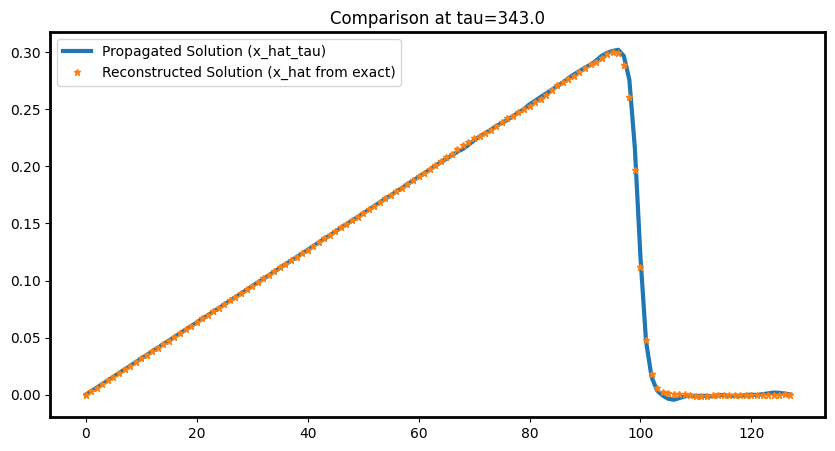

In [42]:
# Randomly select an index for comparison
random_index = random.randint(0, len(taus) - 1)

# Extract the propagated solution and the solution from exact latents
propagated_x_hat_tau = x_hat_taus[random_index]  # From propagated latents
x_hat_from_exact = x_hats_from_exact[random_index]  # From exact latents

print(propagated_x_hat_tau.shape, x_hat_from_exact.shape)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(propagated_x_hat_tau.detach().numpy().squeeze(),linewidth = 3, label="Propagated Solution (x_hat_tau)")
plt.plot(x_hat_from_exact.detach().numpy().squeeze(), marker = "*", markersize = 5, linestyle = "None", label="Reconstructed Solution (x_hat from exact)")
plt.legend()
plt.title(f"Comparison at tau={taus[random_index].item()}")
plt.show()

In [43]:
taus_np = np.array(taus)
actual_means = np.array(means_from_exact).squeeze()
propagated_means = np.array(z_taus).squeeze()

print("taus_np shape:", taus_np.shape)  # Shape of taus
print("actual_means shape:", actual_means.shape)  # Shape of actual latents
print("propagated_means shape:", propagated_means.shape)  # Shape of propagated latents

taus_np shape: (275, 1)
actual_means shape: (275, 2)
propagated_means shape: (275, 2)


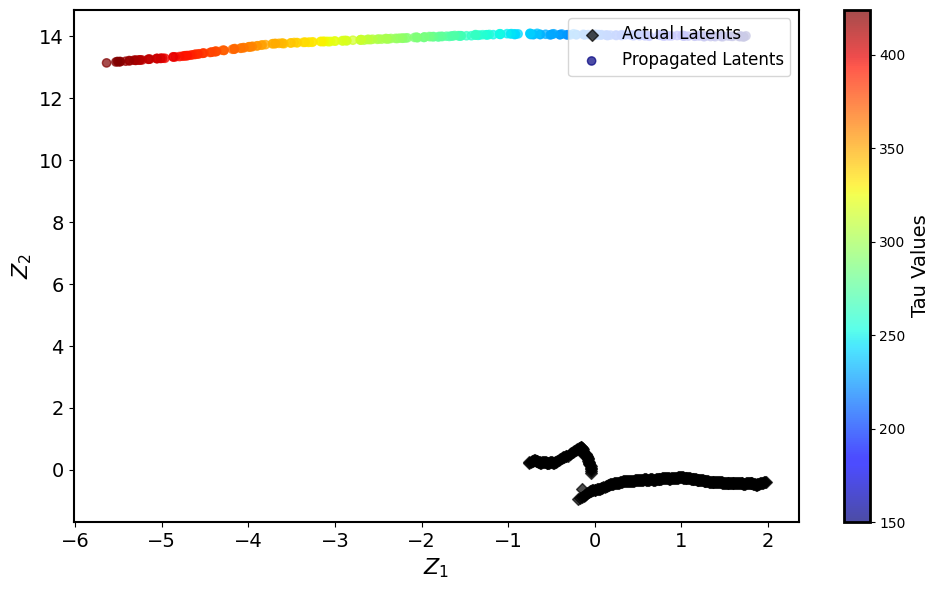

In [44]:
# Create a figure and axis using the object-oriented interface
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.get_cmap('jet')

# Scatter plot for actual latents (in blue)
ax.scatter(
    actual_means[:, 0], actual_means[:, 1],
    color='black', label='Actual Latents', alpha=0.7, marker='D'
)

# Scatter plot for propagated latents (colored by tau values)
sc = ax.scatter(
    propagated_means[:, 0], propagated_means[:, 1],
    c=taus_np, cmap=cmap, label='Propagated Latents', alpha=0.7, marker='o'
)

# Add a colorbar to indicate tau values
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Tau Values', fontsize=14)

# Add labels and a title
ax.set_xlabel(r'$Z_1$', fontsize=16)
ax.set_ylabel(r'$Z_2$', fontsize=16)


# Increase axis thickness
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Increase axis tick label size
ax.tick_params(axis='both', which='major', labelsize=14)

# Add a legend
ax.legend(fontsize=12, loc='upper right')

# Add a grid for better visualization
ax.grid(alpha=0.0)

# Set the y-limits AFTER all plotting commands
#ax.set_ylim(-1.50, 0.42)

# Ensure the plot layout is clean
plt.tight_layout()

# Save the figure
#plt.savefig("many_to_one_re_1000.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

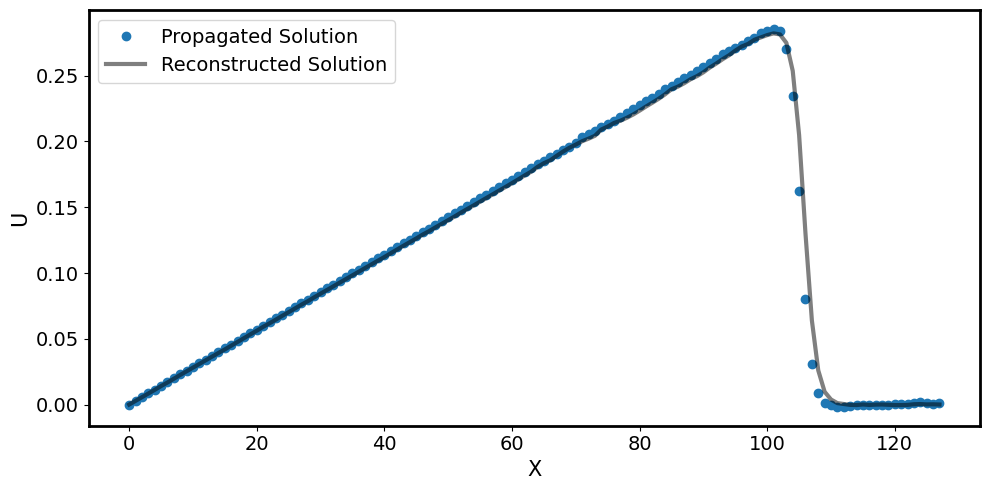

In [45]:
# Passing the first actual latent through the decoder and the first propagated latent

random_index = -1 

# Extract the propagated solution and the solution from exact latents
propagated_x_hat_tau = x_hat_taus[random_index]  # From propagated latents
x_hat_from_exact = x_hats_from_exact[random_index]  # From exact latents

#print(propagated_x_hat_tau.shape, x_hat_from_exact.shape)

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the propagated solution
ax.plot(
    propagated_x_hat_tau.detach().numpy().squeeze(),
    "o", markersize=6, label="Propagated Solution"
)

# Plot the reconstructed solution
ax.plot(
    x_hat_from_exact.detach().numpy().squeeze(),
    color="black", linewidth=3, alpha=0.5, label="Reconstructed Solution"
)

# Add legend and title
ax.legend(fontsize=14)
#ax.set_title(f"Comparison at tau={taus[random_index].item()}", fontsize=14)

# Adjust axis properties
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.tick_params(axis='both', which='major', labelsize=14)

# Add labels for clarity
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("U", fontsize=15)

#ax.set_ylim(-0.02, 0.5)
# Adjust layout for cleaner visualization
plt.tight_layout()

# Saving the Image
#plt.savefig("final_tau_many_to_one_re_1000.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


### Many to One For List of Re's

In [46]:
# Parameters
TRANGE = (0, 2)
Re_values = list(np.arange(400, 2400, 50))  # List of Re values [400-2400: 200]
t0 = 0.10  # Initial time
dt = 2.0 / 500.0
taus = torch.arange(150, 425, dtype=torch.float32).unsqueeze(-1)  # Shape: (250, 1)

# Initialize lists to store latents for all Re values
all_actual_means, all_propagated_means, all_taus, all_re_labels = [], [], [], []

for Re_value in Re_values:
    # Convert Re to tensor
    Re_value_tensor = torch.tensor([Re_value], dtype=torch.float32)

    # Generate initial state x_t
    x_t = torch.tensor(exact_solution(Re_value, t0)[None, None, :], dtype=torch.float32)  # Shape: (1, 1, 128)

    # Lists to store results for this Re
    x_hat_taus, z_taus = [], []

    # Propagate latents for each tau
    for tau in taus:
        tau = tau.unsqueeze(0)  # Shape: (1, 1)
        Re_value_expanded = Re_value_tensor.unsqueeze(0)  # Shape: (1, 1)

        with torch.no_grad():
            x_hat, x_hat_tau, mean, log_var, z_tau = eighty_K_concat_model(x_t, tau, Re_value_expanded)

        x_hat_taus.append(x_hat_tau.squeeze(0))  # Remove batch dimension
        z_taus.append(z_tau.squeeze(0))  # Remove batch dimension

    # Convert lists to tensors for further processing
    x_hat_taus = torch.stack(x_hat_taus)  # Shape: (num_taus, 128)
    z_taus = torch.stack(z_taus)  # Shape: (num_taus, latent_dim)

    # Compute physical times for each tau
    physical_times = t0 + taus.squeeze(-1).numpy() * dt

    # Compute exact solutions for these times
    exact_solns = torch.tensor(
        np.array([exact_solution(Re_value, t) for t in physical_times]), dtype=torch.float32
    )  # Shape: (num_taus, 128)

    # Pass all exact solutions through the VAE encoder and save their x_hat and mean
    x_hats_from_exact, means_from_exact = [], []

    for exact_sol in exact_solns:
        exact_sol = exact_sol.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 128)
        with torch.no_grad():
            mean, _ = eighty_K_concat_model.encoder(exact_sol)  # Shape: (1, latent_dim)
            x_hat = eighty_K_concat_model.decoder(mean).squeeze(0)  # Shape: (128,)
        x_hats_from_exact.append(x_hat)
        means_from_exact.append(mean.squeeze(0))

    # Convert lists to tensors for further processing
    means_from_exact = torch.stack(means_from_exact)  # Shape: (num_taus, latent_dim)

    # Store results for this Re
    all_actual_means.append(means_from_exact)
    all_propagated_means.append(z_taus)
    all_taus.append(taus.squeeze(-1).numpy())
    all_re_labels.append([Re_value] * len(taus))

# Concatenate all results for plotting
all_actual_means = torch.cat(all_actual_means, dim=0).numpy()  # Shape: (num_taus * num_Re, latent_dim)
all_propagated_means = torch.cat(all_propagated_means, dim=0).numpy()  # Shape: (num_taus * num_Re, latent_dim)
all_taus = np.concatenate(all_taus, axis=0)  # Shape: (num_taus * num_Re,)
all_re_labels = np.concatenate(all_re_labels, axis=0)  # Shape: (num_taus * num_Re,)

print("Shape of all_actual_means:", all_actual_means.shape)
print("Shape of all_propagated_means:", all_propagated_means.shape)
print("Shape of all_taus:", all_taus.shape)
print("Shape of all_re_labels:", all_re_labels.shape)

Shape of all_actual_means: (11000, 1, 2)
Shape of all_propagated_means: (11000, 1, 2)
Shape of all_taus: (11000,)
Shape of all_re_labels: (11000,)


Shape of all_actual_means (after squeeze): (11000, 2)
Shape of all_propagated_means (after squeeze): (11000, 2)
Shape of all_taus: (11000,)


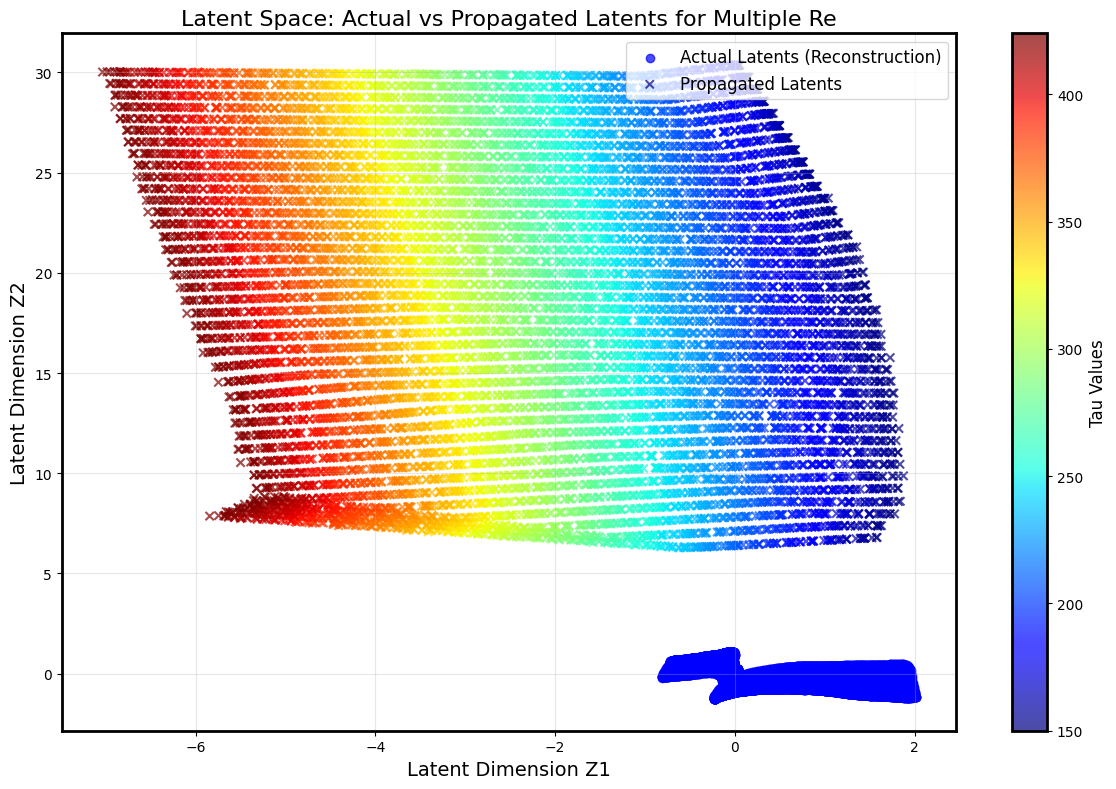

In [47]:
# Remove the extra dimension
all_actual_means = all_actual_means.squeeze(1)  
all_propagated_means = all_propagated_means.squeeze(1) 

# Check shapes after squeezing
print("Shape of all_actual_means (after squeeze):", all_actual_means.shape)
print("Shape of all_propagated_means (after squeeze):", all_propagated_means.shape)
print("Shape of all_taus:", all_taus.shape)

# Check latent dimension
latent_dim = all_actual_means.shape[1]

# Plotting
plt.figure(figsize=(12, 8))
cmap = plt.get_cmap('jet')

if latent_dim == 1:
    # Plot 1D latents against tau values
    plt.scatter(
        all_taus, all_actual_means[:, 0],
        color='blue', label='Actual Latents (Reconstruction)', alpha=0.7, marker='o'
    )
    sc = plt.scatter(
        all_taus, all_propagated_means[:, 0],
        c=all_taus, cmap=cmap, label='Propagated Latents', alpha=0.7, marker='x'
    )
    plt.xlabel('Tau Values', fontsize=14)
    plt.ylabel('Latent Dimension Z1', fontsize=14)
else:
    # Scatter plot for 2D latents
    plt.scatter(
        all_actual_means[:, 0], all_actual_means[:, 1],
        color='blue', label='Actual Latents (Reconstruction)', alpha=0.7, marker='o'
    )
    sc = plt.scatter(
        all_propagated_means[:, 0], all_propagated_means[:, 1],
        c=all_taus, cmap=cmap, label='Propagated Latents', alpha=0.7, marker='x'
    )
    plt.xlabel('Latent Dimension Z1', fontsize=14)
    plt.ylabel('Latent Dimension Z2', fontsize=14)

# Add a colorbar to indicate tau values
cbar = plt.colorbar(sc)
cbar.set_label('Tau Values', fontsize=12)

# Add title, legend, and grid
plt.title('Latent Space: Actual vs Propagated Latents for Multiple Re', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Decoder Jacobian

torch.Size([275, 1, 128]) --- torch.Size([275, 1, 2])
torch.Size([275, 1, 128]) --- torch.Size([275, 1, 2])
torch.Size([1, 128]) torch.Size([1, 128])


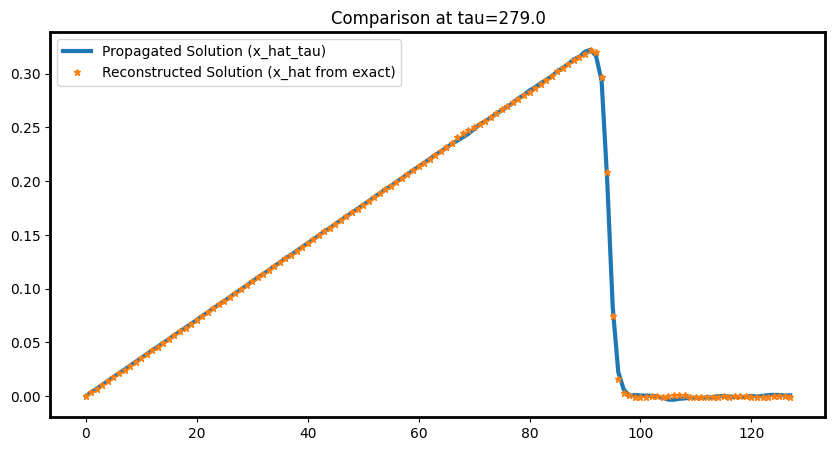

In [48]:
# Parameters
TRANGE = (0, 2)
Re_value = torch.tensor([1200], dtype=torch.float32)  # Interpolation Re value; choose some Re
t0 = 0.10  # Initial time
dt = 2.0 / 500.0
taus = torch.arange(150, 425, dtype=torch.float32).unsqueeze(-1)  # Shape: (250, 1) - choosing a range of Re

# Generate initial state x_t
x_t = torch.tensor(exact_solution(Re_value.item(), t0)[None, None, :], dtype=torch.float32)  # Shape: (1, 1, 128)

# Lists to store results
x_hat_taus, z_taus = [], []

# Propagate latents for each tau
for tau in taus:
    tau = tau.unsqueeze(0)  # Shape: (1, 1)
    Re_value_expanded = Re_value.unsqueeze(0)  # Shape: (1, 1)

    with torch.no_grad():
        x_hat, x_hat_tau, mean, log_var, z_tau = eighty_K_concat_model(x_t, tau, Re_value_expanded)

    x_hat_taus.append(x_hat_tau.squeeze(0))  # Remove batch dimension
    z_taus.append(z_tau.squeeze(0))  # Remove batch dimension

# Convert lists to tensors for further processing
x_hat_taus = torch.stack(x_hat_taus)  # Shape: (num_taus, 128)
z_taus = torch.stack(z_taus)  # Shape: (num_taus, latent_dim)
print(f"{x_hat_taus.shape} --- {z_taus.shape}")


# Compute physical times for each tau
physical_times = t0 + taus.squeeze(-1).numpy() * dt

# Compute exact solutions for these times
exact_solns = torch.tensor(
    np.array([exact_solution(Re_value.item(), t) for t in physical_times]), dtype=torch.float32
)  # Shape: (num_taus, 128)

# Pass all exact solutions through the VAE encoder and save their x_hat and mean
eighty_K_concat_model.eval()
x_hats_from_exact, means_from_exact = [], []

for exact_sol in exact_solns:
    exact_sol = exact_sol.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 128)
    with torch.no_grad():
        mean, _ = eighty_K_concat_model.encoder(exact_sol)  # Shape: (1, latent_dim)
        x_hat = eighty_K_concat_model.decoder(mean).squeeze(0)  # Shape: (128,)
    x_hats_from_exact.append(x_hat)
    means_from_exact.append(mean.squeeze(0))

# Convert lists to tensors for further processing
x_hats_from_exact = torch.stack(x_hats_from_exact)  # Shape: (num_taus, 128)
means_from_exact = torch.stack(means_from_exact)  # Shape: (num_taus, latent_dim)
print(f"{x_hats_from_exact.shape} --- {means_from_exact.shape}")

# Randomly select an index for comparison
random_index = random.randint(0, len(taus) - 1)

# Extract the propagated solution and the solution from exact latents
propagated_x_hat_tau = x_hat_taus[random_index]  # From propagated latents
x_hat_from_exact = x_hats_from_exact[random_index]  # From exact latents

print(propagated_x_hat_tau.shape, x_hat_from_exact.shape)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(propagated_x_hat_tau.detach().numpy().squeeze(),linewidth = 3, label="Propagated Solution (x_hat_tau)")
plt.plot(x_hat_from_exact.detach().numpy().squeeze(), marker = "*", markersize = 5, linestyle = "None", label="Reconstructed Solution (x_hat from exact)")
plt.legend()
plt.title(f"Comparison at tau={taus[random_index].item()}")
plt.show()

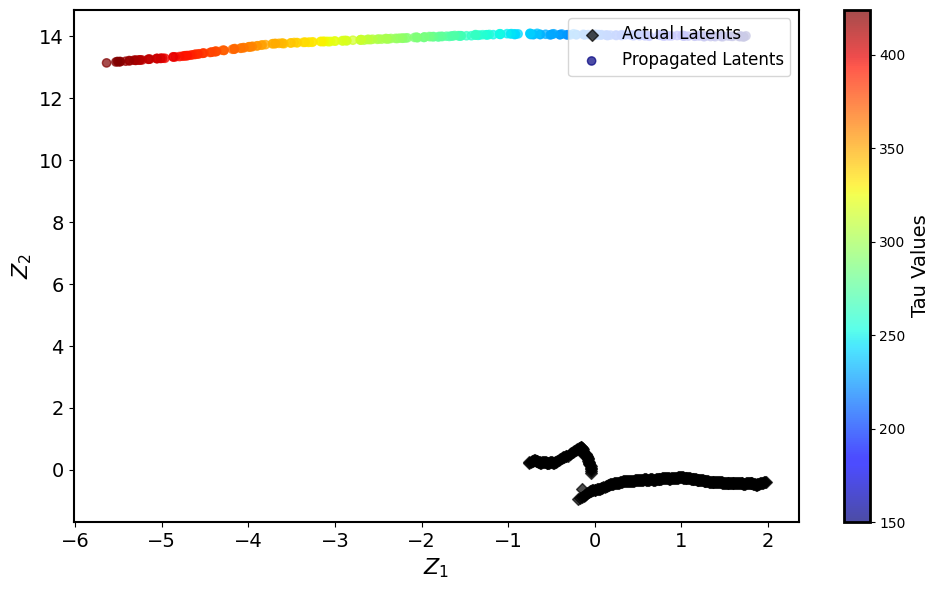

In [49]:
# Create a figure and axis using the object-oriented interface
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.get_cmap('jet')

# Scatter plot for actual latents (in blue)
ax.scatter(
    actual_means[:, 0], actual_means[:, 1],
    color='black', label='Actual Latents', alpha=0.7, marker='D'
)

# Scatter plot for propagated latents (colored by tau values)
sc = ax.scatter(
    propagated_means[:, 0], propagated_means[:, 1],
    c=taus_np, cmap=cmap, label='Propagated Latents', alpha=0.7, marker='o'
)

# Add a colorbar to indicate tau values
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Tau Values', fontsize=14)

# Add labels and a title
ax.set_xlabel(r'$Z_1$', fontsize=16)
ax.set_ylabel(r'$Z_2$', fontsize=16)


# Increase axis thickness
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Increase axis tick label size
ax.tick_params(axis='both', which='major', labelsize=14)

# Add a legend
ax.legend(fontsize=12, loc='upper right')

# Add a grid for better visualization
ax.grid(alpha=0.0)
# Ensure the plot layout is clean
plt.tight_layout()
# Display the plot
plt.show()

In [50]:
from torch.autograd.functional import jacobian
random_index = 178
# Choose your two latent vectors for comparison (batch of 1, 2D vector)

z_original = means_from_exact[random_index].unsqueeze(0)  # shape: (1, 2)
z_propagated = z_taus[random_index].unsqueeze(0)  # shape: (1, 2)

# Define a function that takes in z and returns x_hat (high-dimensional)
def decoder_function(z):
    return eighty_K_concat_model.decoder(z)

# Compute Jacobians
J_original = jacobian(decoder_function, z_original)  # shape: (1, 128, 1, 2)
J_propagated = jacobian(decoder_function, z_propagated)  # shape: (1, 128, 1, 2)

# Remove extra batch dimensions
J_original = J_original.squeeze(0).squeeze(1)  # shape: (128, 2)
J_propagated = J_propagated.squeeze(0).squeeze(1)  # shape: (128, 2)

print(f"J_original shape: {J_original.shape}, J_propagated shape: {J_propagated.shape}")

# 1. Frobenius norm of the difference
jacobian_difference_norm = torch.norm(J_original - J_propagated, p='fro')
print(f"Frobenius norm of Jacobian difference: {jacobian_difference_norm.item()}")

J_original shape: torch.Size([1, 128, 1, 1, 2]), J_propagated shape: torch.Size([1, 128, 1, 1, 2])
Frobenius norm of Jacobian difference: 1.730745553970337


In [51]:
# Squeeze unnecessary dimensions -> shape [128, 2]
J_original_matrix = J_original.squeeze().cpu()  # torch.Size([128, 2])
J_propagated_matrix = J_propagated.squeeze().cpu()  # torch.Size([128, 2])

# Compute singular values for both Jacobians
J_original_U, J_original_S, J_original_Vh = torch.linalg.svd(J_original_matrix)
J_propagated_U, J_propagated_S, J_propagated_Vh = torch.linalg.svd(J_propagated_matrix)

# Move to numpy for plotting
sv_original = J_original_S.numpy()  # Shape: (2,)
sv_propagated = J_propagated_S.numpy()  # Shape: (2,)

print("Singular Values of J_original:", sv_original)
print("Singular Values of J_propagated:", sv_propagated)

Singular Values of J_original: [1.2520472  0.15934451]
Singular Values of J_propagated: [0.47438276 0.00853863]


In [52]:
fro_norm_J_original = torch.norm(J_original, p='fro').item()
fro_norm_J_propagated = torch.norm(J_propagated, p='fro').item()

# # Create figure
# plt.figure(figsize=(12, 4))

# # === Left Plot: Singular Value Decay ===
# plt.subplot(1, 2, 1)
# plt.plot(sv_original, marker='o', markersize=8, color='blue', linewidth=2)
# plt.plot(sv_propagated, marker='x', markersize=8, color='orange', linewidth=2)

# plt.tick_params(axis='both', which='major', labelsize=16)
# plt.grid(True)

# # === Right Plot: Frobenius Norm Bar Plot ===
# plt.subplot(1, 2, 2)
# plt.bar(['J_original', 'J_propagated'],
#         [fro_norm_J_original, fro_norm_J_propagated],
#         color=['blue', 'orange'])

# plt.ylim(0, max(fro_norm_J_original, fro_norm_J_propagated) * 1.2)
# plt.tick_params(axis='both', which='major', labelsize=16)
# plt.grid(axis='y')

# # === Layout & Spacing ===
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.25)  # Increase horizontal spacing here (try 0.4 or 0.5)

# # === Save figure ===
# #plt.savefig("Frobenius_norm_decoder.png", dpi=300)
# plt.show()

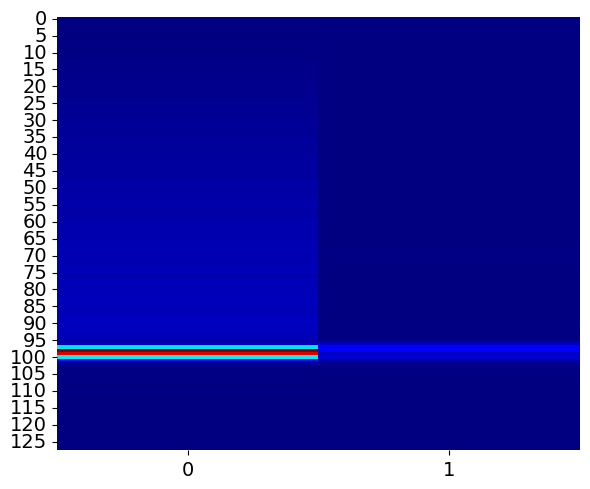

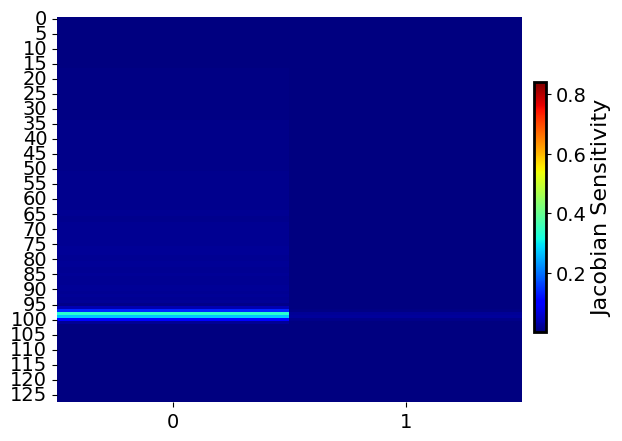

In [53]:
import seaborn as sns 
# === Preprocess Jacobians ===
J_original_matrix = J_original.squeeze().cpu().numpy()        # shape (128, 2)
J_propagated_matrix = J_propagated.squeeze().cpu().numpy()    # shape (128, 2)

# === Common color scale limits for consistency ===
vmin = min(np.min(np.abs(J_original_matrix)), np.min(np.abs(J_propagated_matrix)))
vmax = max(np.max(np.abs(J_original_matrix)), np.max(np.abs(J_propagated_matrix)))

# ===============================
# === First figure (J_original) ===
# ===============================
fig1, ax1 = plt.subplots(figsize=(6, 5))

sns.heatmap(
    np.abs(J_original_matrix),
    ax=ax1,
    cmap='jet',
    vmin=vmin,
    vmax=vmax,
    cbar=False   # No colorbar for the first figure
)

ax1.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

# Save the first figure
#plt.savefig("Jacobian_Sensitivity_J_original_NoColorbar.png", dpi=300)

plt.show()
plt.close(fig1)

# ==================================
# === Second figure (J_propagated) ===
# ==================================
fig2, ax2 = plt.subplots(figsize=(6, 5))

sns.heatmap(
    np.abs(J_propagated_matrix),
    ax=ax2,
    cmap='jet',
    vmin=vmin,
    vmax=vmax,
    cbar=False   # We'll add the colorbar manually
)

# Add a colorbar on the right-hand side of the second plot
cbar_ax = fig2.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])

cbar = fig2.colorbar(sm, cax=cbar_ax)
cbar.set_label('Jacobian Sensitivity', fontsize=16)
cbar.ax.tick_params(labelsize=14)

ax2.tick_params(axis='both', which='major', labelsize=14)
plt.subplots_adjust(right=0.9)

# Save the second figure
#plt.savefig("Jacobian_Sensitivity_J_propagated_WithColorbar.png", dpi=300)
#plt.close(fig2)
plt.show()

In [54]:
highlight_range = np.arange(95, 102)

/tmp/ipykernel_474850/745994541.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_hat_original = eighty_K_concat_model.decoder(torch.tensor(z_original)).squeeze().cpu().numpy()
/tmp/ipykernel_474850/745994541.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_hat_propagated = eighty_K_concat_model.decoder(torch.tensor(z_propagated)).squeeze().cpu().numpy()


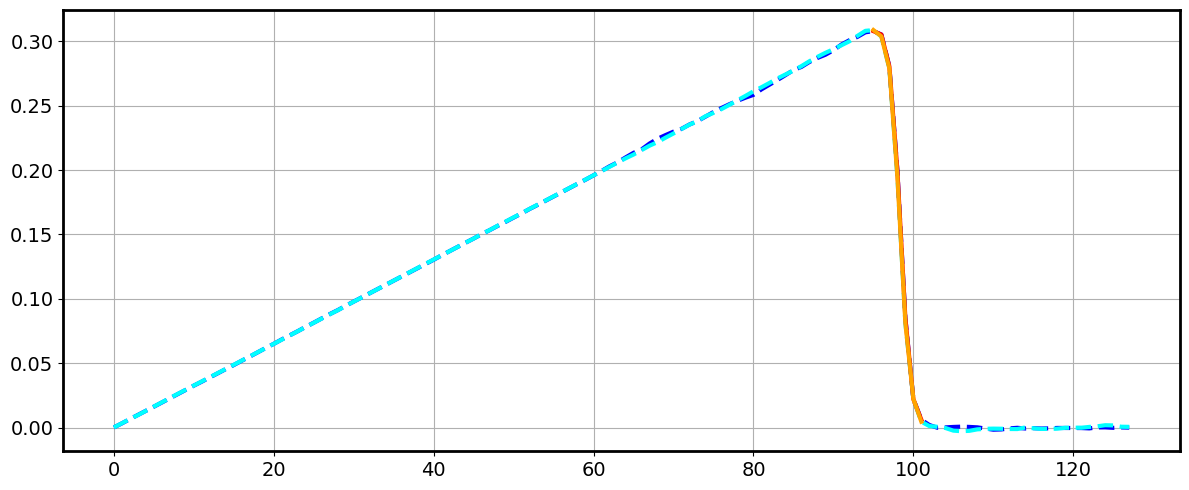

In [55]:
# === Decode latents to high-dimensional states ===
with torch.no_grad():
    x_hat_original = eighty_K_concat_model.decoder(torch.tensor(z_original)).squeeze().cpu().numpy()
    x_hat_propagated = eighty_K_concat_model.decoder(torch.tensor(z_propagated)).squeeze().cpu().numpy()

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 5))

# Plot full reconstructions
ax.plot(x_hat_original, linestyle='--', color='blue', linewidth=3)
ax.plot(x_hat_propagated, linestyle='--', color='cyan', linewidth=3)

# Plot sensitive regions
ax.plot(highlight_range, x_hat_original[highlight_range], color='red', linestyle='-', linewidth=3)
ax.plot(highlight_range, x_hat_propagated[highlight_range], color='orange', linestyle='-', linewidth=3)

# Increase tick size, no titles/labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True)

plt.tight_layout()
#plt.savefig("Reconstructed_Outputs_with_Sensitive_Regions.png", dpi=300)
plt.show()

In [56]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# import torch

# # === Decode states ===
# with torch.no_grad():
#     x_hat_original = eighty_K_concat_model.decoder(torch.tensor(z_original)).squeeze().cpu().numpy()
#     x_hat_propagated = eighty_K_concat_model.decoder(torch.tensor(z_propagated)).squeeze().cpu().numpy()

# # === Jacobians ===
# J_original_matrix = J_original.squeeze().cpu().numpy()
# J_propagated_matrix = J_propagated.squeeze().cpu().numpy()

# mod_jacobian_original = np.abs(J_original_matrix[:, 0])
# mod_jacobian_propagated = np.abs(J_propagated_matrix[:, 0])

# # === Shared color range ===
# all_vals = np.concatenate([mod_jacobian_original, mod_jacobian_propagated])
# vmin, vmax = all_vals.min(), all_vals.max()

# # === Colored line helper ===
# def make_colored_line(ax, signal, color_array, cmap='coolwarm', linewidth=3):
#     x = np.arange(len(signal))
#     points = np.array([x, signal]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
#     norm = plt.Normalize(vmin=vmin, vmax=vmax)
#     lc = LineCollection(segments, cmap=cmap, norm=norm)
#     lc.set_array(color_array)
#     lc.set_linewidth(linewidth)
#     ax.add_collection(lc)
#     ax.set_xlim(x.min(), x.max())
#     ax.set_ylim(signal.min() - 0.01, signal.max() + 0.01)
#     ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#     ax.tick_params(axis='both', which='major', labelsize=16)
#     for spine in ['top', 'right']:
#         ax.spines[spine].set_visible(False)
#     return lc

# # === Plot ===
# fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# # Left: Original
# make_colored_line(axs[0], x_hat_original, mod_jacobian_original)
# axs[0].set_title("Original", fontsize=18)

# # Right: Propagated
# lc = make_colored_line(axs[1], x_hat_propagated, mod_jacobian_propagated)
# axs[1].set_title("Propagated", fontsize=18)

# # === Colorbar (wider) ===
# cbar = fig.colorbar(lc, ax=axs, orientation='vertical', pad=0.03, shrink=0.9, aspect=40)
# cbar.ax.tick_params(labelsize=16)
# cbar.set_label("Jacobian Magnitude", fontsize=16)

# plt.tight_layout()
# plt.show()


/tmp/ipykernel_474850/2152029055.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_hat_original = eighty_K_concat_model.decoder(torch.tensor(z_original)).squeeze().cpu().numpy()
/tmp/ipykernel_474850/2152029055.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_hat_propagated = eighty_K_concat_model.decoder(torch.tensor(z_propagated)).squeeze().cpu().numpy()


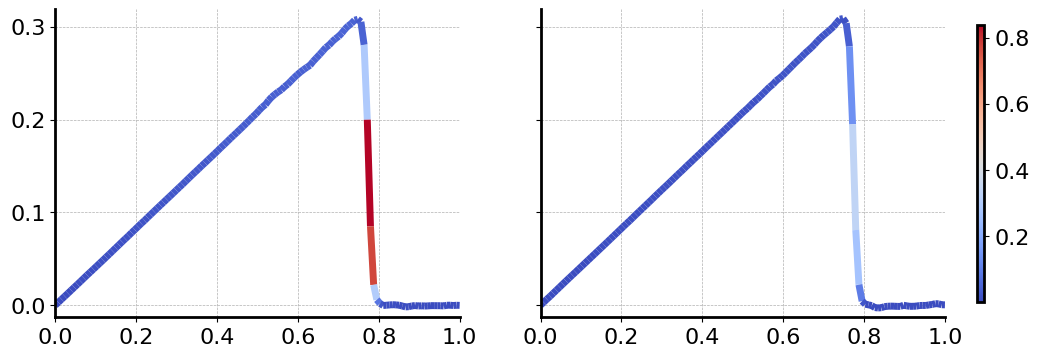

In [57]:
from matplotlib.collections import LineCollection

# === Decode states ===
with torch.no_grad():
    x_hat_original = eighty_K_concat_model.decoder(torch.tensor(z_original)).squeeze().cpu().numpy()
    x_hat_propagated = eighty_K_concat_model.decoder(torch.tensor(z_propagated)).squeeze().cpu().numpy()

# === Jacobians ===
J_original_matrix = J_original.squeeze().cpu().numpy()
J_propagated_matrix = J_propagated.squeeze().cpu().numpy()

mod_jacobian_original = np.abs(J_original_matrix[:, 0])
mod_jacobian_propagated = np.abs(J_propagated_matrix[:, 0])

# === Shared color range ===
all_vals = np.concatenate([mod_jacobian_original, mod_jacobian_propagated])
vmin, vmax = all_vals.min(), all_vals.max()

# === Colored line helper ===
def make_colored_line(ax, signal, color_array, cmap='coolwarm', linewidth=5):
    x = np.linspace(0.0, 1.0, num=len(signal))  # Normalized x-axis from 0 to 1
    points = np.array([x, signal]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(color_array)
    lc.set_linewidth(linewidth)
    ax.add_collection(lc)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(signal.min() - 0.01, signal.max() + 0.01)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=16)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    return lc

# === Plot ===
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# Left: Original
make_colored_line(axs[0], x_hat_original, mod_jacobian_original)

# Right: Propagated
lc = make_colored_line(axs[1], x_hat_propagated, mod_jacobian_propagated)

# === Colorbar (slightly wider) ===
cbar = fig.colorbar(lc, ax=axs, orientation='vertical', pad=0.03, shrink=0.9, aspect=40)
cbar.ax.tick_params(labelsize=16)

# === Show or save ===
plt.savefig("jacobian_sensitivity.png", dpi=300, bbox_inches='tight')
plt.show()


#### Perturbation analysis

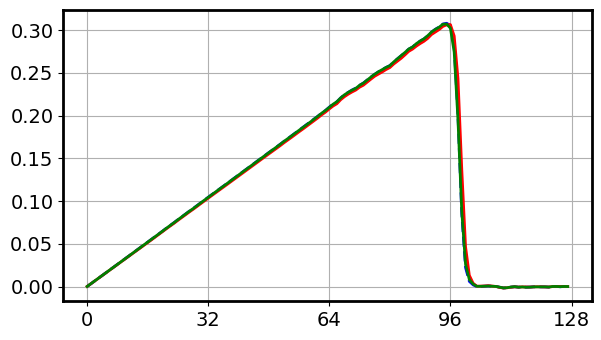

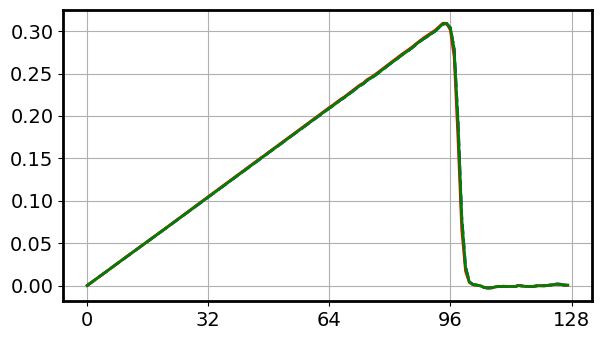

In [58]:
# === Delta for perturbation ===
delta = 0.06  # Choose a small perturbation

# === Squeeze batch & sequence dims ===
z_original_vector = z_original.squeeze().clone()       # Shape: [2]
z_propagated_vector = z_propagated.squeeze().clone()   # Shape: [2]

# === Create perturbed versions ===
# Original
z_original_perturbed_0 = z_original_vector.clone()
z_original_perturbed_1 = z_original_vector.clone()

z_original_perturbed_0[0] += delta  # Perturb latent dim 0
z_original_perturbed_1[1] += delta  # Perturb latent dim 1

# Propagated
z_propagated_perturbed_0 = z_propagated_vector.clone()
z_propagated_perturbed_1 = z_propagated_vector.clone()

z_propagated_perturbed_0[0] += delta
z_propagated_perturbed_1[1] += delta

# === Reshape for decoder input ===
z_original = z_original_vector.unsqueeze(0)  # Shape [1, 2]
z_original_perturbed_0 = z_original_perturbed_0.unsqueeze(0)
z_original_perturbed_1 = z_original_perturbed_1.unsqueeze(0)

z_propagated = z_propagated_vector.unsqueeze(0)
z_propagated_perturbed_0 = z_propagated_perturbed_0.unsqueeze(0)
z_propagated_perturbed_1 = z_propagated_perturbed_1.unsqueeze(0)

# === Pass through decoder ===
with torch.no_grad():
    # Original decoder reconstructions
    x_hat_original = eighty_K_concat_model.decoder(z_original).squeeze().cpu().numpy()
    x_hat_original_perturbed_0 = eighty_K_concat_model.decoder(z_original_perturbed_0).squeeze().cpu().numpy()
    x_hat_original_perturbed_1 = eighty_K_concat_model.decoder(z_original_perturbed_1).squeeze().cpu().numpy()

    # Propagated decoder reconstructions
    x_hat_propagated = eighty_K_concat_model.decoder(z_propagated).squeeze().cpu().numpy()
    x_hat_propagated_perturbed_0 = eighty_K_concat_model.decoder(z_propagated_perturbed_0).squeeze().cpu().numpy()
    x_hat_propagated_perturbed_1 = eighty_K_concat_model.decoder(z_propagated_perturbed_1).squeeze().cpu().numpy()

# === Plotting ===
x_axis = np.arange(len(x_hat_original))  # Spatial domain of the reconstructed state

# === Original Latent Space Perturbations Plot ===
fig1, ax1 = plt.subplots(figsize=(6, 3.5))

ax1.plot(x_axis, x_hat_original, color='blue', linestyle='--', linewidth=2)
ax1.plot(x_axis, x_hat_original_perturbed_0, color='red', linestyle='-', linewidth=2)
ax1.plot(x_axis, x_hat_original_perturbed_1, color='green', linestyle='-', linewidth=2)

ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xticks(np.linspace(0, len(x_axis), 5).astype(int))  # Optional: control tick locations

plt.tight_layout()
#plt.savefig("perturbation_effect_original_latent.png", dpi=300)
plt.show()

# === Propagated Latent Space Perturbations Plot ===
fig2, ax2 = plt.subplots(figsize=(6, 3.5))

ax2.plot(x_axis, x_hat_propagated, color='blue', linestyle='--', linewidth=2)
ax2.plot(x_axis, x_hat_propagated_perturbed_0, color='red', linestyle='-', linewidth=2)
ax2.plot(x_axis, x_hat_propagated_perturbed_1, color='green', linestyle='-', linewidth=2)

ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xticks(np.linspace(0, len(x_axis), 5).astype(int))  # Optional: control tick locations

plt.tight_layout()
#plt.savefig("perturbation_effect_propagated_latent.png", dpi=300)
plt.show()

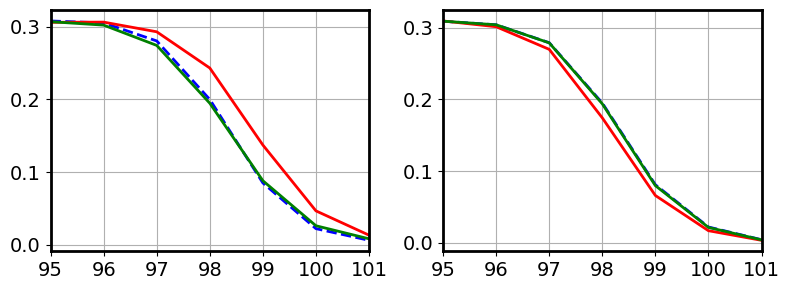

In [59]:
# === Extract the zoomed-in regions for plotting ===
x_axis_zoom = highlight_range

# Original
x_hat_original_zoom = x_hat_original[highlight_range]
x_hat_original_perturbed_0_zoom = x_hat_original_perturbed_0[highlight_range]
x_hat_original_perturbed_1_zoom = x_hat_original_perturbed_1[highlight_range]

# Propagated
x_hat_propagated_zoom = x_hat_propagated[highlight_range]
x_hat_propagated_perturbed_0_zoom = x_hat_propagated_perturbed_0[highlight_range]
x_hat_propagated_perturbed_1_zoom = x_hat_propagated_perturbed_1[highlight_range]

# === Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # One row, two columns

# === Plot zoomed-in for z_original perturbations ===
axes[0].plot(x_axis_zoom, x_hat_original_zoom, color='blue', linestyle='--', linewidth=2)
axes[0].plot(x_axis_zoom, x_hat_original_perturbed_0_zoom, color='red', linestyle='-', linewidth=2)
axes[0].plot(x_axis_zoom, x_hat_original_perturbed_1_zoom, color='green', linestyle='-', linewidth=2)

# === Plot zoomed-in for z_propagated perturbations ===
axes[1].plot(x_axis_zoom, x_hat_propagated_zoom, color='blue', linestyle='--', linewidth=2)
axes[1].plot(x_axis_zoom, x_hat_propagated_perturbed_0_zoom, color='red', linestyle='-', linewidth=2)
axes[1].plot(x_axis_zoom, x_hat_propagated_perturbed_1_zoom, color='green', linestyle='-', linewidth=2)

# === Customize axes ===
for ax in axes:
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(x_axis_zoom)
    ax.set_xlim([95, 101])

plt.tight_layout()
#plt.savefig("Perturbation_zoom_highlight_region.png", dpi=300)
plt.show()

#### Pullback Metric

In [60]:
# Compute metric tensors
g_original = J_original_matrix.T @ J_original_matrix  # shape (2, 2)
g_propagated = J_propagated_matrix.T @ J_propagated_matrix  # shape (2, 2)

print("Metric Tensor at z_original:\n", g_original)
print("Metric Tensor at z_propagated:\n", g_propagated)

# Eigen decomposition
eigvals_orig, eigvecs_orig = np.linalg.eigh(g_original)
eigvals_prop, eigvecs_prop = np.linalg.eigh(g_propagated)

print("Eigenvalues (z_original):", eigvals_orig)
print("Eigenvectors (z_original):\n", eigvecs_orig)

print("\nEigenvalues (z_propagated):", eigvals_prop)
print("Eigenvectors (z_propagated):\n", eigvecs_prop)

# Determinants
det_orig = np.linalg.det(g_original)
det_prop = np.linalg.det(g_propagated)

print("Determinant (z_original):", det_orig)
print("Determinant (z_propagated):", det_prop)

Metric Tensor at z_original:
 [[ 1.5665071  -0.0414525 ]
 [-0.0414525   0.02650565]]
Metric Tensor at z_propagated:
 [[0.22419506 0.013753  ]
 [0.013753   0.00091685]]
Eigenvalues (z_original): [0.02539067 1.5676221 ]
Eigenvectors (z_original):
 [[-0.02688798 -0.99963844]
 [-0.99963844  0.02688798]]

Eigenvalues (z_propagated): [7.290812e-05 2.250390e-01]
Eigenvectors (z_propagated):
 [[ 0.06124865 -0.9981225 ]
 [-0.9981225  -0.06124865]]
Determinant (z_original): 0.03980298
Determinant (z_propagated): 1.6407172e-05


In [61]:
# # Prepare data
# determinants = [det_orig, det_prop]

# # Bar labels using LaTeX math
# labels = [r'$\det(g(\tilde{z}))$', r'$\det(g(\hat{z}))$']

# # Set figure and axis
# fig, ax = plt.subplots(figsize=(8, 6))  # Paper-quality aspect ratio

# # Bar colors: choose distinct ones
# colors = ['#1f77b4', '#ff7f0e']  # Blue and orange from matplotlib default palette

# # Create bar plot
# bars = ax.bar([0, 1], determinants, color=colors, width=0.5)

# # Y-axis on log scale
# ax.set_yscale('log')

# # Remove x-axis labels (tick labels)
# ax.set_xticks([])

# # Legend using labels and bar handles
# ax.legend(bars, labels, fontsize=18, loc='upper right')

# # Y-axis label
# ax.set_ylabel('Determinant', fontsize=20)

# # Increase tick size
# ax.tick_params(axis='both', which='major', labelsize=20, length=6, width=2)
# ax.tick_params(axis='both', which='minor', labelsize=16, length=4, width=1)

# # Remove top and right spines for a cleaner look
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # Optional: grid for y-axis
# ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Tight layout for saving or display
# plt.tight_layout()

# # Optional: save for paper
# plt.savefig('determinants_plot.png', dpi=300, bbox_inches='tight')

# # Show plot
# plt.show()

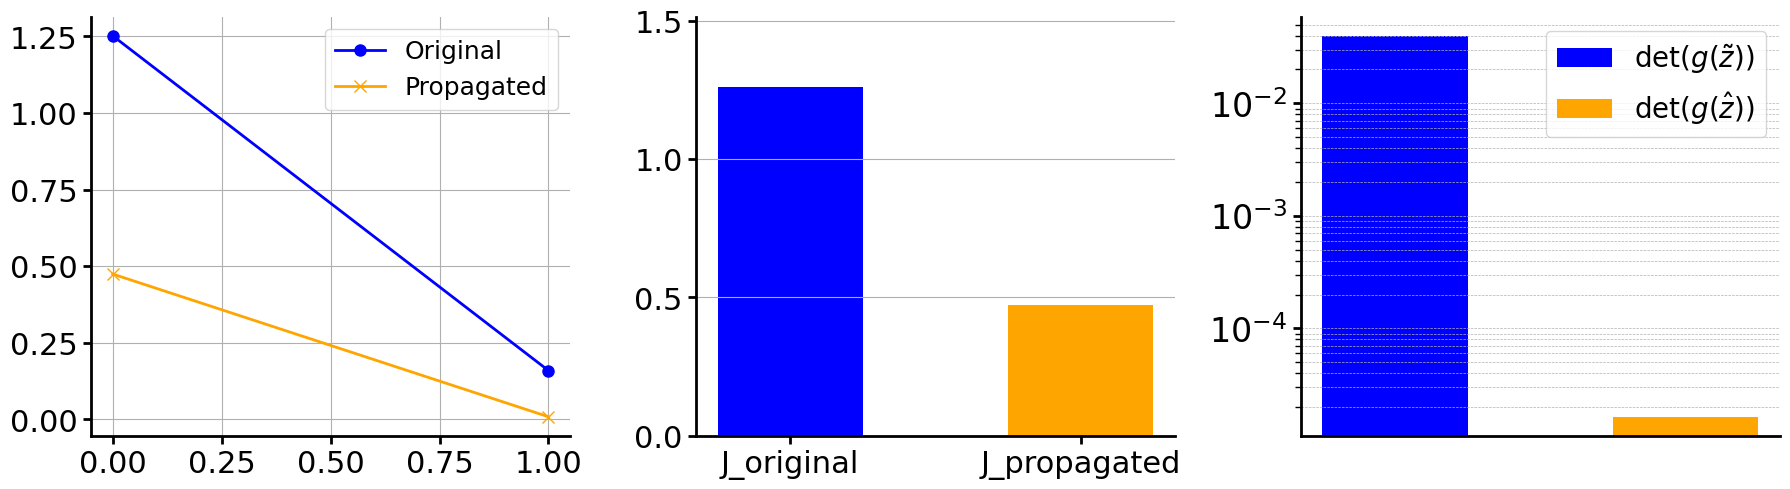

In [71]:
import matplotlib.pyplot as plt
import torch

# === Frobenius Norms ===
fro_norm_J_original = torch.norm(J_original, p='fro').item()
fro_norm_J_propagated = torch.norm(J_propagated, p='fro').item()

# === Determinants ===
determinants = [det_orig, det_prop]
det_labels = [r'$\det(g(\tilde{z}))$', r'$\det(g(\hat{z}))$']
colors = ['blue', 'orange']

# === Create Figure with 3 Subplots ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# === Left Plot: Singular Value Decay ===
axs[0].plot(sv_original, marker='o', markersize=8, color='blue', linewidth=2, label='Original')
axs[0].plot(sv_propagated, marker='x', markersize=8, color='orange', linewidth=2, label='Propagated')
axs[0].tick_params(axis='both', which='major', labelsize=22, length=6, width=2)
axs[0].tick_params(axis='both', which='minor', labelsize=22, length=4, width=1)
axs[0].grid(True)
axs[0].legend(fontsize=18, loc='upper right')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# === Middle Plot: Frobenius Norm Bar Plot ===
axs[1].bar(['J_original', 'J_propagated'],
           [fro_norm_J_original, fro_norm_J_propagated],
           color=['blue', 'orange'], width=0.5)
axs[1].set_ylim(0, max(fro_norm_J_original, fro_norm_J_propagated) * 1.2)
axs[1].tick_params(axis='both', which='major', labelsize=22, length=6, width=2)
axs[1].tick_params(axis='both', which='minor', labelsize=16, length=4, width=1)
axs[1].grid(axis='y')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# === Right Plot: Determinant Bar Plot (Log Scale) ===
bars = axs[2].bar([0, 1], determinants, color=colors, width=0.5)
axs[2].set_yscale('log')
axs[2].set_xticks([])
axs[2].tick_params(axis='y', which='major', labelsize=24, length=6, width=2)
axs[2].tick_params(axis='y', which='minor', labelsize=16, length=4, width=1)
axs[2].legend(bars, det_labels, fontsize=20, loc='upper right')
axs[2].yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

# === Layout and Save ===
plt.tight_layout()
plt.savefig("geometry_comparison_final.png", dpi=300, bbox_inches='tight')
plt.show()

## Random Results from AE LSTM

In [63]:
lstm_testing_data.shape

(5, 500, 3)

Using device: cuda:0
Re:  2450.0


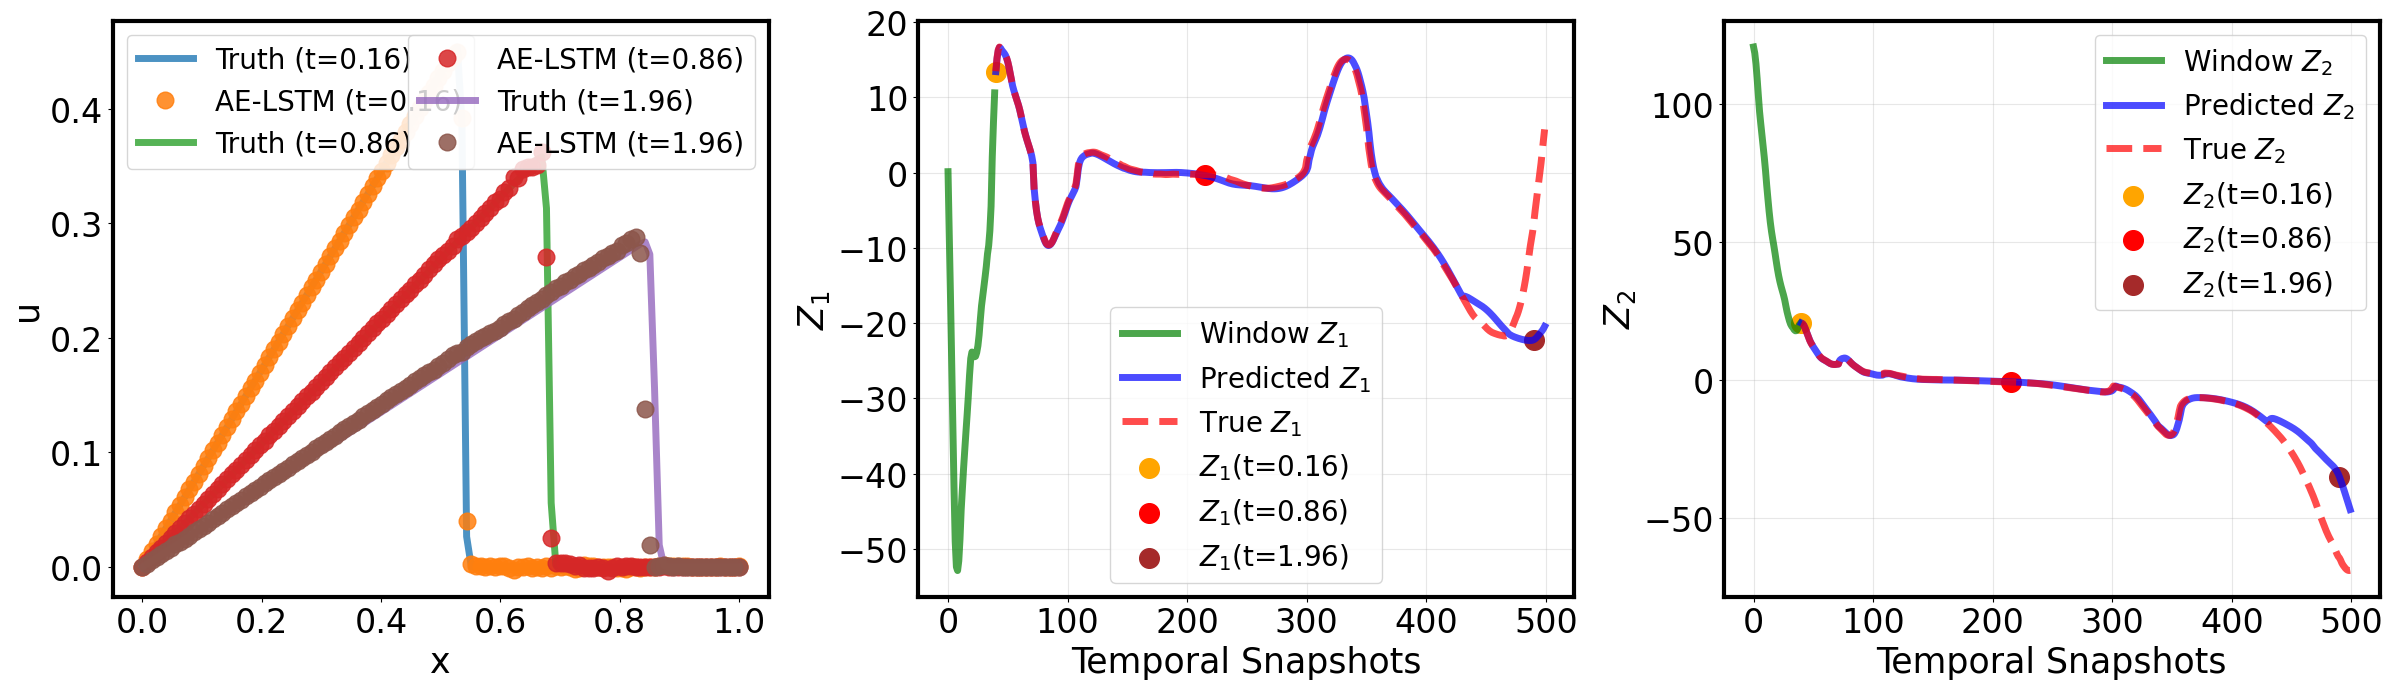

In [64]:
# ======= DEVICE SETUP =======
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move models to device
lstm_model.to(device)
AE_decoder.to(device)

# Test case info (Replace with your data if needed)
num_test_snapshots, num_time_steps, _ = lstm_testing_data.shape
sim_num = 4
time_window = 40

# Time setup
t_0 = 0.16  # Initial time
dt = 2.0 / 500.0

# Indices in latent space and their corresponding physical times
indices = [0, 175, 450]  # Example latent indices
t_physical = [t_0 + idx * dt for idx in indices]

# ======= AUTOREGRESSIVE PREDICTION SETUP =======
input_seq = np.zeros((1, time_window, 3), dtype=np.float32)
predictions = np.zeros((num_time_steps - time_window, 2), dtype=np.float32)
y_true = np.zeros((num_time_steps - time_window, 2), dtype=np.float32)

# Seed the first time window
input_seq[0, :, :] = lstm_testing_data[sim_num, 0:time_window, :]

lstm_model.eval()

# ======= AUTOREGRESSIVE PREDICTION LOOP =======
sample = 0

with torch.no_grad():
    for t in range(time_window, num_time_steps):
        inp_tensor = torch.from_numpy(input_seq).float().to(device)
        pred = lstm_model(inp_tensor)
        pred_np = pred.cpu().numpy()[0, :]
        predictions[sample, :] = pred_np
        y_true[sample, :] = lstm_testing_data[sim_num, t, 0:2]

        temp = input_seq[0, 1:time_window, :].copy()
        input_seq[0, 0:time_window-1, :] = temp
        input_seq[0, time_window-1, 0:2] = pred_np

        sample += 1

# ======= DECODE HIGH-DIMENSIONAL FIELDS =======
decoded_states = []
true_states = []
Re_value = r_num = (np.unique(lstm_testing_data[sim_num, :, 2]) * 1000).squeeze()
print("Re: ", Re_value)

for idx, t in zip(indices, t_physical):
    latent_pred_tensor = torch.tensor(predictions[idx, :], dtype=torch.float32).to(device)
    x_hat_tau_pred = AE_decoder(latent_pred_tensor)
    decoded_states.append(x_hat_tau_pred.detach().cpu().numpy().squeeze())
    true_state = exact_solution(Re_value, t)
    true_states.append(true_state)

# ======= PLOTTING =======
fig, axs = plt.subplots(1, 3, figsize=(24, 7))  # Bigger figure size

# Universal style variables
lw = 5            # Line width
ms = 12           # Marker size
scatter_size = 200  # Scatter point size
legend_fontsize = 20
label_fontsize = 25
tick_fontsize = 24

x_space = np.linspace(0.0, 1.0, num=128)

# --- Subplot 1: High-dimensional states ---
for i, t in enumerate(t_physical):
    axs[0].plot(x_space, true_states[i], alpha=0.8, linewidth=lw, label=f"Truth (t={t:.2f})")
    axs[0].plot(x_space, decoded_states[i], 'o', alpha=0.85, markersize=ms, label=f"AE-LSTM (t={t:.2f})")

axs[0].set_xlabel("x", fontsize=label_fontsize)
axs[0].set_ylabel("u", fontsize=label_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

handles, labels = axs[0].get_legend_handles_labels()
truth_handles = handles[:len(t_physical)]
truth_labels = labels[:len(t_physical)]
lstm_handles = handles[len(t_physical):]
lstm_labels = labels[len(t_physical):]

legend1 = axs[0].legend(truth_handles, truth_labels, fontsize=legend_fontsize, loc='upper left')
legend2 = axs[0].legend(lstm_handles, lstm_labels, fontsize=legend_fontsize, loc='upper right')
axs[0].add_artist(legend1)

# --- Subplot 2: Z1 Evolution ---
x_pred = np.arange(time_window, num_time_steps)
x_window = np.arange(time_window)

axs[1].plot(x_window, lstm_testing_data[sim_num, :time_window, 0], label="Window $Z_1$", color='green', alpha=0.7, linewidth=lw)
axs[1].plot(x_pred, predictions[:, 0], label="Predicted $Z_1$", color='blue', alpha=0.7, linewidth=lw)
axs[1].plot(x_pred, lstm_testing_data[sim_num, time_window:, 0], 'r--', label="True $Z_1$", linewidth=lw, alpha=0.7)

axs[1].scatter(indices[0] + time_window, predictions[indices[0], 0], color='orange', s=scatter_size, label=f"$Z_1$(t={t_physical[0]:.2f})")
axs[1].scatter(indices[1] + time_window, predictions[indices[1], 0], color='red', s=scatter_size, label=f"$Z_1$(t={t_physical[1]:.2f})")
axs[1].scatter(indices[2] + time_window, predictions[indices[2], 0], color='brown', s=scatter_size, label=f"$Z_1$(t={t_physical[2]:.2f})")

axs[1].set_xlabel("Temporal Snapshots", fontsize=label_fontsize)
axs[1].set_ylabel("$Z_1$", fontsize=label_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)
axs[1].legend(fontsize=legend_fontsize)
axs[1].grid(alpha=0.3)

# --- Subplot 3: Z2 Evolution ---
axs[2].plot(x_window, lstm_testing_data[sim_num, :time_window, 1], label="Window $Z_2$", color='green', alpha=0.7, linewidth=lw)
axs[2].plot(x_pred, predictions[:, 1], label="Predicted $Z_2$", color='blue', alpha=0.7, linewidth=lw)
axs[2].plot(x_pred, lstm_testing_data[sim_num, time_window:, 1], 'r--', label="True $Z_2$", linewidth=lw, alpha=0.7)

axs[2].scatter(indices[0] + time_window, predictions[indices[0], 1], color='orange', s=scatter_size, label=f"$Z_2$(t={t_physical[0]:.2f})")
axs[2].scatter(indices[1] + time_window, predictions[indices[1], 1], color='red', s=scatter_size, label=f"$Z_2$(t={t_physical[1]:.2f})")
axs[2].scatter(indices[2] + time_window, predictions[indices[2], 1], color='brown', s=scatter_size, label=f"$Z_2$(t={t_physical[2]:.2f})")

axs[2].set_xlabel("Temporal Snapshots", fontsize=label_fontsize)
axs[2].set_ylabel("$Z_2$", fontsize=label_fontsize)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)
axs[2].legend(fontsize=legend_fontsize)
axs[2].grid(alpha=0.3)

# --- Styling for all plots ---
for ax in axs:
    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

plt.tight_layout()

# Optional save
#plt.savefig("Re_2450_AELSTM.png", dpi=300, bbox_inches='tight')
plt.show()